# Text Augmentation using LLMs
Improving the performance on text classification by generating augmented text using LLMs for
under-represented categories

## Project Overview

### Authors
*   Sejal Agarwal
*   Siddharth Jain

### Reponsibilities

Siddharth will handle dataset creation, cleaning,
and augmentation, specifically making the AG
News dataset imbalanced by reducing instances
in the Science/Technology category and generating
synthetic data using GPT-4/BERT. Sejal will
focus on training classification models using Linear
Regression, SVM, and Transformers on both
the imbalanced and augmented datasets as well as
evaluating the model’s performance across several
metrics (accuracy, precision, recall, F1, confusion
matrix). Both members will collaborate on documentation
and visualization, using GitHub for version
control, and Google Docs & Overleaf for documentation.

### Motivation

We aim to explore how text augmentation with
LLMs can enhance classification performance, especially
in imbalanced datasets. Many textual
datasets have significant imbalances in the number
of examples for each class, which can cause
classification models to perform poorly on the minority
classes, leading to skewed predictions and
a lack of generalization. Imbalanced datasets are
an issue in real-world applications where the occurrence
of certain categories is naturally lower
than others. Improving recognition of these minority
categories is essential in fields like healthcare,
finance, and NLP applications for more accurate
decision-making.

## Setup & Imports

In [ ]:
# Required imports
!pip install transformers datasets scikit-learn imbalanced-learn joblib

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import joblib
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Mount Google Drive and Define Utility Functions

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define a directory for saving models
model_save_dir = "/content/drive/MyDrive/cs682/Models"
os.makedirs(model_save_dir, exist_ok=True)

# Function to save models
def save_model(model, model_name):
    save_path = os.path.join(model_save_dir, f"{model_name}.joblib")
    joblib.dump(model, save_path)
    print(f"Model saved to {save_path}")

# Function to load models
def load_model(model_name):
    load_path = os.path.join(model_save_dir, f"{model_name}.joblib")
    if os.path.exists(load_path):
        model = joblib.load(load_path)
        print(f"Model loaded from {load_path}")
        return model
    else:
        print(f"No saved model found at {load_path}")
        return None

## Data

### Loading the Dataset

In [ ]:
# Load the AG News dataset from Hugging Face
dataset = load_dataset("ag_news")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [ ]:
# Convert the dataset into a Pandas DataFrame
train_data = pd.DataFrame(dataset['train'])
test_data = pd.DataFrame(dataset['test'])

# Display the column names and dataset size
print(f"Columns: {train_data.columns}")
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Check category distribution
print("Category distribution in the training set:")
print(train_data['label'].value_counts())

# Resampling to ensure each category has 5000 samples
desired_sample_count = 5000
resampled_dataframes = []

for label in train_data['label'].unique():
    category_data = train_data[train_data['label'] == label]
    if len(category_data) > desired_sample_count:
        # Undersample
        resampled_category_data = category_data.sample(n=desired_sample_count, random_state=42)
    else:
        # Oversample
        resampled_category_data = category_data.sample(n=desired_sample_count, replace=True, random_state=42)
    resampled_dataframes.append(resampled_category_data)

# Combine all resampled data into a single DataFrame
balanced_train_data = pd.concat(resampled_dataframes, ignore_index=True)

# Shuffle the balanced dataset
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the new category distribution
print("Category distribution after resampling:")
print(balanced_train_data['label'].value_counts())

# Display a few samples from the balanced train dataset
balanced_train_data.head()
train_data = balanced_train_data

Columns: Index(['text', 'label'], dtype='object')
Training set size: 120000
Test set size: 7600
Category distribution in the training set:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64
Category distribution after resampling:
label
1    5000
2    5000
3    5000
0    5000
Name: count, dtype: int64


**Label Mapping**

0: World

1: Sports

2: Business

3: Science/Technology

In [ ]:
# Check the class distribution in the training set
train_data['label'].value_counts().sort_index()

,count
label,
0,5000
1,5000
2,5000
3,5000


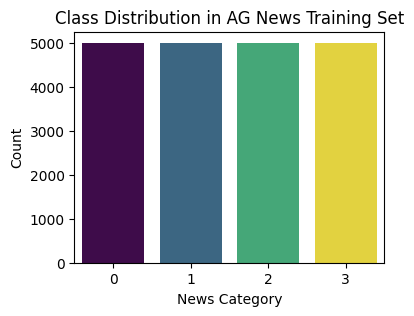

In [ ]:
# Plot class distribution in the training set
plt.figure(figsize=(4, 3))
sns.countplot(x='label', data=train_data, hue='label', palette='viridis', legend=False)
plt.title('Class Distribution in AG News Training Set')
plt.xlabel('News Category')
plt.ylabel('Count')
plt.show()

### Data Preprocessing

In [ ]:
# Text Cleaning

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stop words
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning
train_data['text_cleaned'] = train_data['text'].apply(clean_text)
test_data['text_cleaned'] = test_data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Remove duplicates
train_data.drop_duplicates(subset=['text_cleaned'], inplace=True)

# Remove rows with null values
train_data.dropna(subset=['text_cleaned'], inplace=True)

In [ ]:
# Split the dataset into train and test sets
X_train = train_data['text_cleaned']
y_train = train_data['label']
X_test = test_data['text_cleaned']
y_test = test_data['label']

In [ ]:
# Vectorize the text
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Train and Test Models on the Balanced Dataset

In [ ]:
# Train or load Logistic Regression on the balanced dataset
log_reg = load_model("logistic_regression_balanced")
if log_reg is None:
    log_reg = LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1)
    log_reg.fit(X_train_tfidf, y_train)
    save_model(log_reg, "logistic_regression_balanced")

# Train or load SVM on the balanced dataset
svm = load_model("svm_balanced")
if svm is None:
    svm = LinearSVC(random_state=42, dual=False)
    svm.fit(X_train_tfidf, y_train)
    save_model(svm, "svm_balanced")

# Evaluate models on the test set
for model, name in [(log_reg, "Logistic Regression"), (svm, "SVM")]:
    print(f"Testing {name} on Balanced Dataset:")
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

No saved model found at /content/drive/MyDrive/cs682/Models/logistic_regression_balanced.joblib
Model saved to /content/drive/MyDrive/cs682/Models/logistic_regression_balanced.joblib
No saved model found at /content/drive/MyDrive/cs682/Models/svm_balanced.joblib
Model saved to /content/drive/MyDrive/cs682/Models/svm_balanced.joblib
Testing Logistic Regression on Balanced Dataset:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.93      0.96      0.95      1900
           2       0.85      0.86      0.86      1900
           3       0.87      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Testing SVM on Balanced Dataset:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1900
           1       0.94      0.96      0

## Create Imbalanced Datasets

### Severe Under-sampling Across Multiple Classes

In [ ]:
def severe_under_sampling(df, target_classes_fractions):
    sampled_dfs = []
    for target, fraction in target_classes_fractions.items():
        class_data = df[df['label'] == target]
        sampled_size = int(len(class_data) * fraction)
        # Check if sampled_size is greater than 0 to avoid errors
        if sampled_size > 0:
            sampled_dfs.append(class_data.sample(n=sampled_size, random_state=42))
    return pd.concat(sampled_dfs).reset_index(drop=True)

# Set the level of under-sampling
target_classes_fractions = {
    3: 0.2,  # Reduce Science/Technology by 80%
    2: 0.4,  # Reduce Business by 60%
    0: 1.0,  # Keep World unchanged (100%)
    1: 1.0   # Keep Sports unchanged (100%)
}

severe_under_sampling_imbalanced_df = severe_under_sampling(train_data, target_classes_fractions)

In [ ]:
severe_under_sampling_imbalanced_df['label'].value_counts().sort_index()

,count
label,
0,4999
1,4998
2,1999
3,999


**Graph**

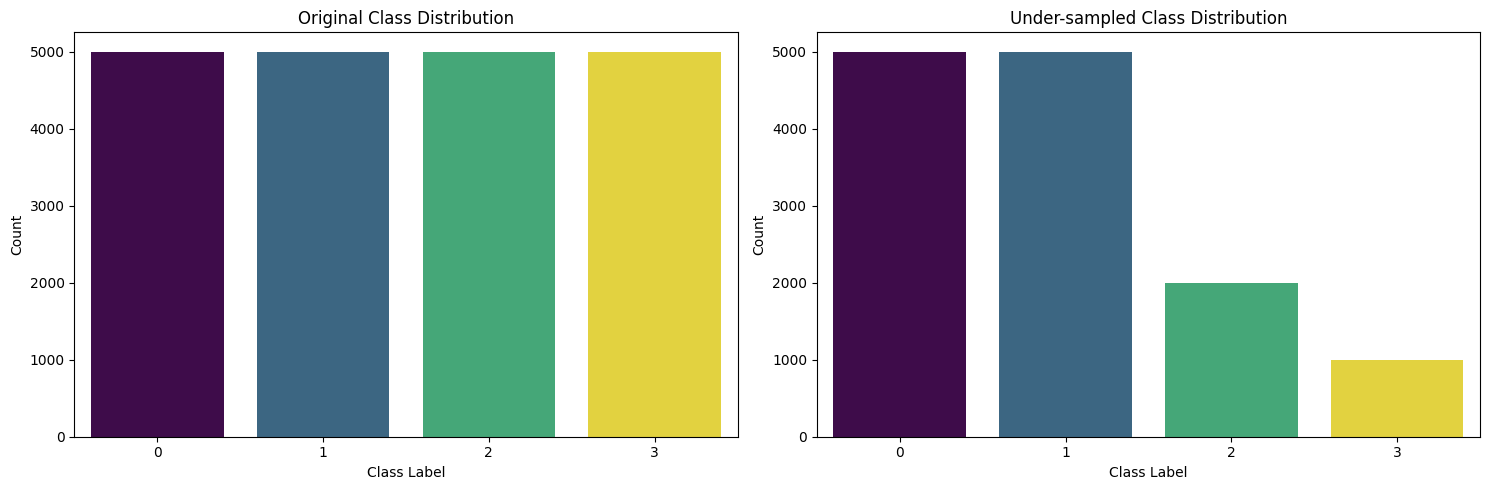

In [ ]:
# Example for comparing before and after
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Original class distribution
sns.countplot(ax=ax[0], x='label', data=train_data, hue='label', palette='viridis', legend=False)
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Count')

# Under-sampled class distribution
sns.countplot(ax=ax[1], x='label', data=severe_under_sampling_imbalanced_df, hue='label', palette='viridis', legend=False)
ax[1].set_title('Under-sampled Class Distribution')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Clustered Minority Instances with Diverse Text Lengths

In [ ]:
def cluster_minority_instances_all_classes(df, minority_class, cluster_size):
    # Filter the minority class data
    minority_data = df[df['label'] == minority_class]
    other_classes_data = df[df['label'] != minority_class]

    # Get the lengths of the texts in the minority class
    lengths = minority_data['text'].apply(lambda x: len(x.split()))
    clustered_data = []

    # Iterate through unique text lengths
    for length in np.unique(lengths):
        length_group = minority_data[lengths == length]
        if len(length_group) > cluster_size:
            # Sample the specified number of instances if there are more than cluster_size
            clustered_data.append(length_group.sample(n=cluster_size, random_state=42))
        else:
            # Append the entire group if it's smaller than or equal to cluster_size
            clustered_data.append(length_group)

    # Combine clustered minority data and other classes data
    clustered_minority_df = pd.concat(clustered_data, axis=0)
    final_df = pd.concat([other_classes_data, clustered_minority_df], axis=0).reset_index(drop=True)

    return final_df

# Example usage:
clustered_minority_df = cluster_minority_instances_all_classes(train_data, minority_class=3, cluster_size=100)

In [ ]:
clustered_minority_df['label'].value_counts().sort_index()

,count
label,
0,4999
1,4998
2,4998
3,3457


**Graph**

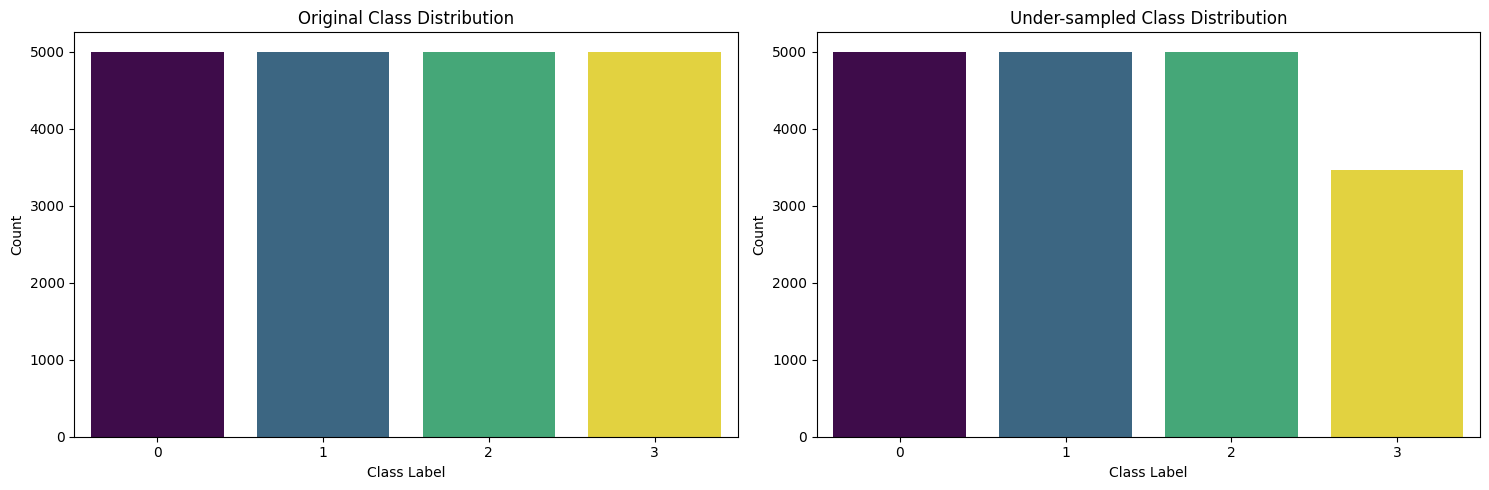

In [ ]:
# Example for comparing before and after
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Original class distribution
sns.countplot(ax=ax[0], x='label', data=train_data, hue='label', palette='viridis', legend=False)
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Count')

# Under-sampled class distribution
sns.countplot(ax=ax[1], x='label', data=clustered_minority_df, hue='label', palette='viridis', legend=False)
ax[1].set_title('Under-sampled Class Distribution')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

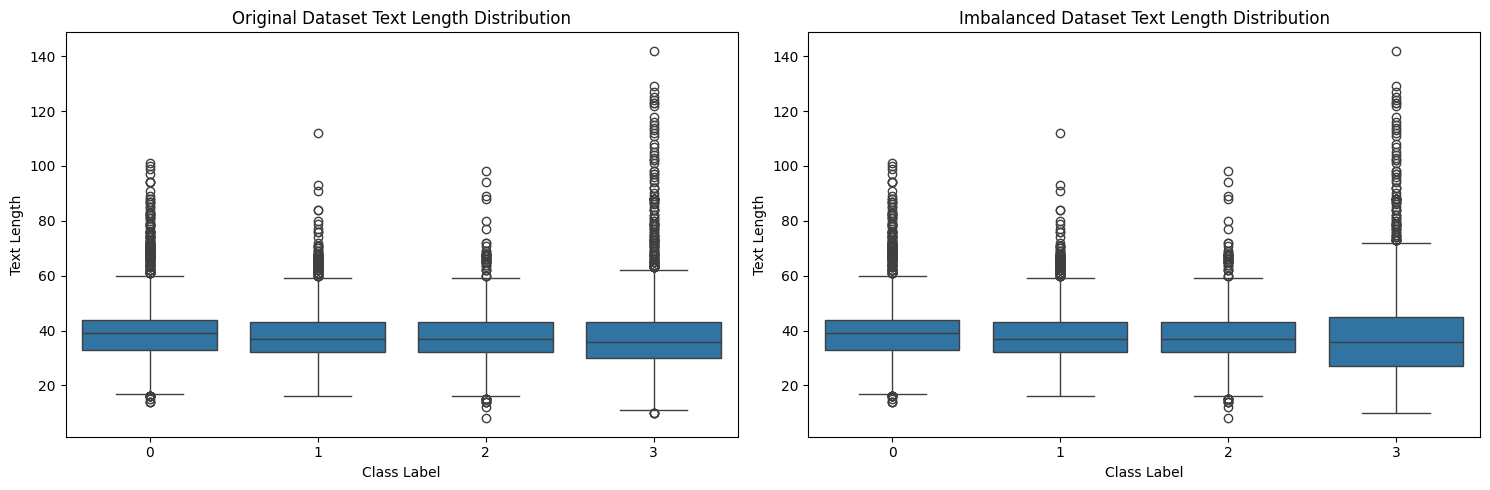

In [ ]:
# Calculate text length for both original and imbalanced datasets
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))
clustered_minority_df['text_length'] = clustered_minority_df['text'].apply(lambda x: len(x.split()))

# Set up side-by-side box plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Original dataset text length distribution
sns.boxplot(ax=ax[0], x='label', y='text_length', data=train_data)
ax[0].set_title('Original Dataset Text Length Distribution')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Text Length')

# Imbalanced dataset text length distribution
sns.boxplot(ax=ax[1], x='label', y='text_length', data=clustered_minority_df)
ax[1].set_title('Imbalanced Dataset Text Length Distribution')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Text Length')

plt.tight_layout()
plt.show()

### Topic-Specific Under-sampling within a Category

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Example DataFrame if not already in Pandas format
# Assuming `train_data` has columns 'label' and 'text_cleaned'

# Initialize the vectorizer to extract frequent words (topics)
vectorizer = CountVectorizer(stop_words='english', max_features=10)

# Dictionary to store the most common topics for each class
class_topics = {}

# Iterate through each class label
for label in train_data['label'].unique():
    # Filter the data for the current class
    class_data = train_data[train_data['label'] == label]

    # Fit and transform the text data to find common words
    X = vectorizer.fit_transform(class_data['text_cleaned'])

    # Get the 10 most common words (features) for this class
    common_words = vectorizer.get_feature_names_out()

    # Store the words as topics for this class
    class_topics[label] = common_words

# Display the top topics for each class
for label, topics in class_topics.items():
    print(f"Top topics for class {label}: {topics}")

Top topics for class 1: ['ap' 'cup' 'game' 'league' 'new' 'night' 'season' 'team' 'win' 'world']
Top topics for class 2: ['company' 'corp' 'million' 'new' 'oil' 'percent' 'prices' 'reuters'
 'said' 'york']
Top topics for class 3: ['ap' 'company' 'internet' 'microsoft' 'new' 'reuters' 'said' 'service'
 'software' 'space']
Top topics for class 0: ['afp' 'ap' 'iraq' 'killed' 'minister' 'new' 'people' 'president'
 'reuters' 'said']


In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Filter the Business class data
business_data = train_data[train_data['label'] == 2]

# Tokenize the cleaned text and remove stopwords
business_data['tokens'] = business_data['text_cleaned'].apply(lambda x: [word for word in x.split() if word not in stop_words])

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(business_data['tokens'])

# Create a corpus (list of bag-of-words)
corpus = [dictionary.doc2bow(text) for text in business_data['tokens']]

<ipython-input-22-9d70005edb02>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_data['tokens'] = business_data['text_cleaned'].apply(lambda x: [word for word in x.split() if word not in stop_words])


In [ ]:
# # Train the LDA model for the Business class data
num_topics = 10  # Specify the number of topics

In [ ]:
# lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
# lda_model.save('/content/drive/MyDrive/cs682/Models/lda_model.gensim')
# dictionary.save('/content/drive/MyDrive/cs682/Models/dictionary.gensim')

In [ ]:
# Load the model and dictionary
lda_model = LdaModel.load('/content/drive/MyDrive/cs682/Models/lda_model.gensim')
dictionary = gensim.corpora.Dictionary.load('/content/drive/MyDrive/cs682/Models/dictionary.gensim')

In [ ]:
# Create a DataFrame to store the top words for each topic
topic_words = {f'Topic {i}': [word for word, _ in lda_model.show_topic(i, topn=10)] for i in range(num_topics)}
topic_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in topic_words.items()]))

# Display the top words for each topic
print(topic_df)

     Topic 0  Topic 1   Topic 2    Topic 3    Topic 4  Topic 5     Topic 6  \
0     profit      oil        us  microsoft         us   market       chief   
1    percent   prices       new       said      rates   google  peoplesoft   
2    reuters       us     sales      court   interest   growth      oracle   
3       said  reuters    growth    company        new   shares   executive   
4   earnings   stocks   economy      yukos    federal    first         bid   
5        lta   dollar      year         us  insurance    price     company   
6        inc      new    retail       news    reuters  percent        said   
7      sales     high    august    billion    reserve   search       board   
8        new    crude  business   european       rate    stock      former   
9  quarterly     york  consumer       corp       said   public        corp   

     Topic 7   Topic 8  Topic 9  
0       drug       inc       us  
1     credit      said  billion  
2       fund   million     said  
3    

In [ ]:
topic_5_words = topic_df['Topic 5'].dropna().tolist()

# Display the words in Topic 5
print("Words in Topic 5:")
print(topic_5_words)

Words in Topic 5:
['market', 'google', 'growth', 'shares', 'first', 'price', 'percent', 'search', 'stock', 'public']


In [ ]:
def topic_specific_under_sampling(df, category, topic_words):
    # Create a mask for the specified category (business class)
    mask_business = (df['label'] == category) & (df['text_cleaned'].apply(lambda x: any(word in x for word in topic_words)))

    # Remove the rows where the mask is True
    cleaned_df = df[~mask_business]

    return cleaned_df

# Example usage:
topic_5_words = ["new", "wireless", "sprint", "online",
                 "walmart", "communications", "nextel", "internet"]
cleaned_train_df = topic_specific_under_sampling(train_data, category=2, topic_words=topic_5_words)

**Graph**

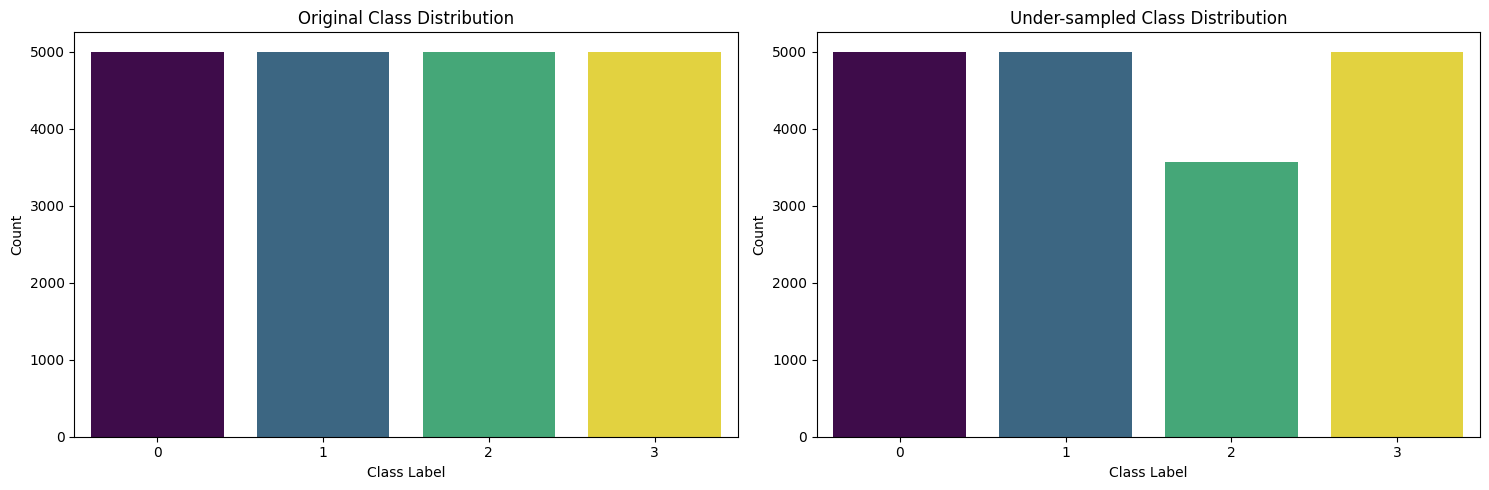

In [ ]:
# Example for comparing before and after
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Original class distribution
sns.countplot(ax=ax[0], x='label', data=train_data, hue='label', palette='viridis', legend=False)
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Count')

# Under-sampled class distribution
sns.countplot(ax=ax[1], x='label', data=cleaned_train_df, hue='label', palette='viridis', legend=False)
ax[1].set_title('Under-sampled Class Distribution')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Progressive Rarity Imbalance (Simulating Long-Tail Distribution)

In [ ]:
def progressive_rarity_imbalance(df, target_classes, rarity_fraction):
    rare_data = []
    common_data = df[~df['label'].isin(target_classes)]

    for target in target_classes:
        class_data = df[df['label'] == target]
        sampled_size = int(len(class_data) * rarity_fraction)
        rare_data.append(class_data.sample(n=sampled_size, random_state=42))

    return pd.concat([common_data] + rare_data).reset_index(drop=True)

# Example usage:
target_classes = [2, 3]  # Classes to create rarity imbalance
rarity_fraction = 0.1  # Fraction of data to retain for the target classes

# Apply the function to create long-tail distribution
long_tail_df = progressive_rarity_imbalance(train_data, target_classes, rarity_fraction)

**Graph**

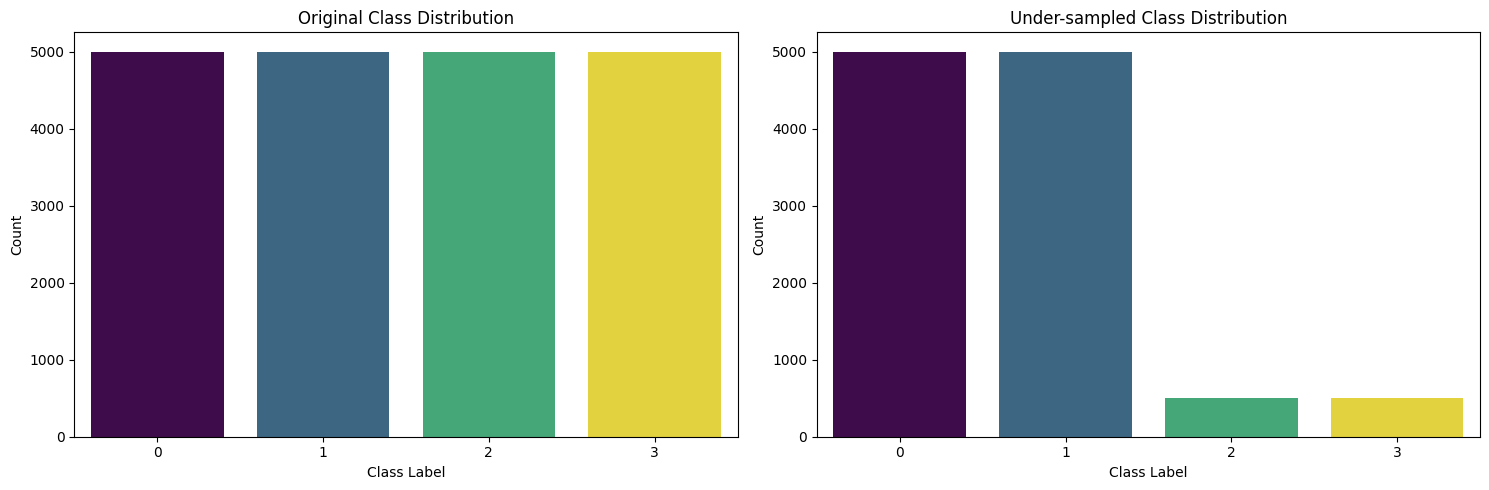

In [ ]:
# Example for comparing before and after
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Original class distribution
sns.countplot(ax=ax[0], x='label', data=train_data, hue='label', palette='viridis', legend=False)
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Count')

# Under-sampled class distribution
sns.countplot(ax=ax[1], x='label', data=long_tail_df, hue='label', palette='viridis', legend=False)
ax[1].set_title('Under-sampled Class Distribution')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
imbalanced_datasets = {
    "Severe Under-sampling": severe_under_sampling_imbalanced_df,
    "Clustered Minority Instances": clustered_minority_df,
    "Topic-Specific Under-sampling": cleaned_train_df,
    "Progressive Rarity Imbalance": long_tail_df
}

## Train and Test Models on the Imbalanced Datasets

In [ ]:
# Train and test models on each imbalanced dataset
for imbalance_type, data in imbalanced_datasets.items():
    X_train_imb = data['text_cleaned']
    y_train_imb = data['label']
    X_train_tfidf_imb = tfidf.fit_transform(X_train_imb)

    # Train Logistic Regression
    log_reg_imb = load_model(f"logistic_regression_{imbalance_type}")
    if log_reg_imb is None:
        log_reg_imb = LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1)
        log_reg_imb.fit(X_train_tfidf_imb, y_train_imb)
        save_model(log_reg_imb, f"logistic_regression_{imbalance_type}")

    # Train SVM
    svm_imb = load_model(f"svm_{imbalance_type}")
    if svm_imb is None:
        svm_imb = LinearSVC(random_state=42, dual=False)
        svm_imb.fit(X_train_tfidf_imb, y_train_imb)
        save_model(svm_imb, f"svm_{imbalance_type}")

    # Test models on the test set
    for model, name in [(log_reg_imb, "Logistic Regression"), (svm_imb, "SVM")]:
        print(f"Testing {name} on {imbalance_type} Dataset:")
        y_pred = model.predict(X_test_tfidf)
        print(classification_report(y_test, y_pred))

No saved model found at /content/drive/MyDrive/cs682/Models/logistic_regression_Severe Under-sampling.joblib
Model saved to /content/drive/MyDrive/cs682/Models/logistic_regression_Severe Under-sampling.joblib
No saved model found at /content/drive/MyDrive/cs682/Models/svm_Severe Under-sampling.joblib
Model saved to /content/drive/MyDrive/cs682/Models/svm_Severe Under-sampling.joblib
Testing Logistic Regression on Severe Under-sampling Dataset:
              precision    recall  f1-score   support

           0       0.27      0.59      0.37      1900
           1       0.30      0.48      0.37      1900
           2       0.21      0.04      0.07      1900
           3       0.24      0.01      0.02      1900

    accuracy                           0.28      7600
   macro avg       0.26      0.28      0.21      7600
weighted avg       0.26      0.28      0.21      7600

Testing SVM on Severe Under-sampling Dataset:
              precision    recall  f1-score   support

           0    

## Apply SMOTE Balancing and Evaluate

In [ ]:
# # Apply SMOTE and train/test models
# smote = SMOTE(random_state=42)

# for imbalance_type, data in imbalanced_datasets.items():
#     X_train_imb = data['text_cleaned']
#     y_train_imb = data['label']
#     X_train_tfidf_imb = tfidf.fit_transform(X_train_imb)

#     # Apply SMOTE
#     X_resampled, y_resampled = smote.fit_resample(X_train_tfidf_imb, y_train_imb)

#     # Train Logistic Regression on SMOTE-balanced dataset
#     log_reg_smote = load_model(f"logistic_regression_smote_{imbalance_type}")
#     if log_reg_smote is None:
#         log_reg_smote = LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1)
#         log_reg_smote.fit(X_resampled, y_resampled)
#         save_model(log_reg_smote, f"logistic_regression_smote_{imbalance_type}")

#     # Train SVM on SMOTE-balanced dataset
#     svm_smote = load_model(f"svm_smote_{imbalance_type}")
#     if svm_smote is None:
#         svm_smote = LinearSVC(random_state=42, dual=False)
#         svm_smote.fit(X_resampled, y_resampled)
#         save_model(svm_smote, f"svm_smote_{imbalance_type}")

#     # Test models on the test set
#     for model, name in [(log_reg_smote, "Logistic Regression"), (svm_smote, "SVM")]:
#         print(f"Testing {name} on SMOTE-Balanced {imbalance_type} Dataset:")
#         y_pred = model.predict(X_test_tfidf)
#         print(classification_report(y_test, y_pred))

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import numpy as np
import scipy.sparse

# Apply SMOTE and train/test models
smote = SMOTE(random_state=42)  # No sparse=True argument, we'll handle the conversion manually

# Iterate over each imbalanced dataset
for imbalance_type, data in imbalanced_datasets.items():
    X_train_imb = data['text_cleaned']
    y_train_imb = data['label']

    # Vectorize the data using TF-IDF (sparse matrix)
    X_train_tfidf_imb = tfidf.fit_transform(X_train_imb)

    # Apply SMOTE to sparse matrix (without converting to dense)
    X_resampled, y_resampled = smote.fit_resample(X_train_tfidf_imb, y_train_imb)

    # Convert the resampled X back to sparse format after SMOTE
    X_resampled_sparse = scipy.sparse.csr_matrix(X_resampled)

    # Train Logistic Regression on SMOTE-balanced dataset
    log_reg_smote = load_model(f"logistic_regression_smote_{imbalance_type}")
    if log_reg_smote is None:
        log_reg_smote = LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1)
        log_reg_smote.fit(X_resampled_sparse, y_resampled)
        save_model(log_reg_smote, f"logistic_regression_smote_{imbalance_type}")

    # Train SVM on SMOTE-balanced dataset
    svm_smote = load_model(f"svm_smote_{imbalance_type}")
    if svm_smote is None:
        svm_smote = LinearSVC(random_state=42, dual=False)
        svm_smote.fit(X_resampled_sparse, y_resampled)
        save_model(svm_smote, f"svm_smote_{imbalance_type}")

    # Vectorize the test data (keep it sparse)
    X_test_tfidf_sparse = tfidf.transform(X_test)  # No need to convert test data to dense

    # Test models on the test set
    for model, name in [(log_reg_smote, "Logistic Regression"), (svm_smote, "SVM")]:
        print(f"Testing {name} on SMOTE-Balanced {imbalance_type} Dataset:")
        y_pred = model.predict(X_test_tfidf_sparse)
        print(classification_report(y_test, y_pred))


No saved model found at /content/drive/MyDrive/cs682/Models/logistic_regression_smote_Severe Under-sampling.joblib
Model saved to /content/drive/MyDrive/cs682/Models/logistic_regression_smote_Severe Under-sampling.joblib
No saved model found at /content/drive/MyDrive/cs682/Models/svm_smote_Severe Under-sampling.joblib
Model saved to /content/drive/MyDrive/cs682/Models/svm_smote_Severe Under-sampling.joblib
Testing Logistic Regression on SMOTE-Balanced Severe Under-sampling Dataset:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1900
           1       0.90      0.97      0.93      1900
           2       0.83      0.83      0.83      1900
           3       0.87      0.76      0.81      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.86      7600
weighted avg       0.87      0.87      0.86      7600

Testing SVM on SMOTE-Balanced Severe Under-sampling Dataset:
              pre

In [ ]:
!pip install transformers datasets

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login

In [ ]:
from transformers import pipeline
import pandas as pd
import random

# Initialize the Hugging Face pipeline for text generation
generator = pipeline('text-generation', model='gpt2')  # You can use other models like GPT-3 or fine-tuned BERT models

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
from tqdm import tqdm
from transformers import pipeline
import torch

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # Use GPU (0) if available, else use CPU (-1)

# Print the device (GPU or CPU)
if device == 0:
    print("Using GPU for text generation.")
else:
    print("Using CPU for text generation.")

# Initialize the Hugging Face pipeline for text generation and move it to the GPU if available
generator = pipeline('text-generation', model='gpt2', device=device)  # device=0 uses GPU

def augment_text_with_llm(df, target_class, n_augmentations=2, batch_size=32):
    """
    Augments the given dataset's minority class using a pre-trained LLM (e.g., GPT-2) and adds a progress bar.

    :param df: DataFrame containing the dataset with 'text_cleaned' and 'label' columns
    :param target_class: The label of the class to augment (minority class)
    :param n_augmentations: Number of synthetic samples to generate for each instance
    :param batch_size: Number of texts to process in one batch
    :return: A DataFrame with the augmented dataset (original + synthetic data)
    """
    # Extract data for the minority class
    target_data = df[df['label'] == target_class]

    augmented_texts = []
    augmented_labels = []

    print(f"Augmenting text for class {target_class}...")

    # Batching the texts for faster generation
    for i in tqdm(range(0, len(target_data), batch_size), desc=f"Augmenting class {target_class}"):
        # Get a batch of text from the minority class
        batch_texts = target_data['text_cleaned'].iloc[i:i+batch_size].tolist()

        # Generate synthetic samples for each text in the batch
        generated_batch = generator(batch_texts, max_new_tokens=50, num_return_sequences=n_augmentations,
                                    pad_token_id=50256, eos_token_id=50256)

        # Add the generated texts to the augmented lists
        for gen_texts in generated_batch:
            for generated_text in gen_texts:
                augmented_texts.append(generated_text['generated_text'])
                augmented_labels.append(target_class)

    # Create a new DataFrame for augmented data
    augmented_df = pd.DataFrame({
        'text_cleaned': augmented_texts,
        'label': augmented_labels
    })

    # Concatenate the augmented data with the original data
    augmented_df = pd.concat([df, augmented_df], ignore_index=True)
    return augmented_df

Using GPU for text generation.


In [ ]:
# Apply LLM-based text augmentation to each imbalanced dataset
augmented_datasets = {}

for imbalance_type, data in imbalanced_datasets.items():
    # Identify the minority class (assuming the last class in the label is the minority)
    minority_class = data['label'].value_counts().idxmin()  # Find the minority class
    print(f"Augmenting text for class {minority_class} in {imbalance_type} dataset...")

    # Augment the minority class using LLMs
    augmented_data = augment_text_with_llm(data, target_class=minority_class, n_augmentations=2)

    # Save the augmented dataset
    augmented_datasets[imbalance_type] = augmented_data
    print(f"Augmented dataset for {imbalance_type} completed.")

Augmenting text for class 3 in Severe Under-sampling dataset...
Augmenting text for class 3...


Augmenting class 3: 100%|██████████| 125/125 [08:04<00:00,  3.87s/it]


Augmented dataset for Severe Under-sampling completed.
Augmenting text for class 3 in Clustered Minority Instances dataset...
Augmenting text for class 3...


Augmenting class 3: 100%|██████████| 433/433 [28:12<00:00,  3.91s/it]


Augmented dataset for Clustered Minority Instances completed.
Augmenting text for class 2 in Topic-Specific Under-sampling dataset...
Augmenting text for class 2...


Augmenting class 2: 100%|██████████| 446/446 [28:31<00:00,  3.84s/it]


Augmented dataset for Topic-Specific Under-sampling completed.
Augmenting text for class 2 in Progressive Rarity Imbalance dataset...
Augmenting text for class 2...


Augmenting class 2: 100%|██████████| 63/63 [04:20<00:00,  4.13s/it]

Augmented dataset for Progressive Rarity Imbalance completed.


In [ ]:
def evaluate_augmented_datasets(augmented_datasets, tfidf, X_test, y_test):
    """
    Evaluates models on the augmented datasets and prints the classification report for each dataset.

    :param augmented_datasets: Dictionary of augmented datasets (key: imbalance type, value: dataset)
    :param tfidf: The fitted TF-IDF vectorizer
    :param X_test: The test set features (already vectorized)
    :param y_test: The test set labels
    """
    for imbalance_type, augmented_data in augmented_datasets.items():
        X_train_augmented = augmented_data['text_cleaned']
        y_train_augmented = augmented_data['label']

        # Vectorize the augmented training data using TF-IDF
        X_train_tfidf_augmented = tfidf.fit_transform(X_train_augmented)

        # Train Logistic Regression on the augmented dataset
        log_reg_augmented = load_model(f"logistic_regression_augmented_{imbalance_type}")
        if log_reg_augmented is None:
            log_reg_augmented = LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1)
            log_reg_augmented.fit(X_train_tfidf_augmented, y_train_augmented)
            save_model(log_reg_augmented, f"logistic_regression_augmented_{imbalance_type}")

        # Train SVM on the augmented dataset
        svm_augmented = load_model(f"svm_augmented_{imbalance_type}")
        if svm_augmented is None:
            svm_augmented = LinearSVC(random_state=42, dual=False)
            svm_augmented.fit(X_train_tfidf_augmented, y_train_augmented)
            save_model(svm_augmented, f"svm_augmented_{imbalance_type}")

        # Vectorize the test data (keep it sparse)
        X_test_tfidf_sparse = tfidf.transform(X_test)  # No need to convert test data to dense

        # Test models on the augmented test set
        for model, name in [(log_reg_augmented, "Logistic Regression"), (svm_augmented, "SVM")]:
            print(f"Testing {name} on Augmented {imbalance_type} Dataset:")
            y_pred = model.predict(X_test_tfidf_sparse)
            print(classification_report(y_test, y_pred))

# Assuming augmented_datasets, tfidf, X_test, and y_test are already defined
evaluate_augmented_datasets(augmented_datasets, tfidf, X_test, y_test)

No saved model found at /content/drive/MyDrive/cs682/Models/logistic_regression_augmented_Severe Under-sampling.joblib
Model saved to /content/drive/MyDrive/cs682/Models/logistic_regression_augmented_Severe Under-sampling.joblib
No saved model found at /content/drive/MyDrive/cs682/Models/svm_augmented_Severe Under-sampling.joblib
Model saved to /content/drive/MyDrive/cs682/Models/svm_augmented_Severe Under-sampling.joblib
Testing Logistic Regression on Augmented Severe Under-sampling Dataset:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1900
           1       0.89      0.97      0.93      1900
           2       0.86      0.76      0.81      1900
           3       0.86      0.75      0.80      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Testing SVM on Augmented Severe Under-sampling Dataset:
           

##.

In [ ]:
dict_data = { 'Imbalanced_Logistic Regression_Clustered Minority Instances': { '0': { 'f1-score': 0.375,
                                                                         'precision': 0.3015075376884422,
                                                                         'recall': 0.49586776859504134,
                                                                         'support': 121.0},
                                                                  '1': { 'f1-score': 0.42857142857142855,
                                                                         'precision': 0.4180327868852459,
                                                                         'recall': 0.4396551724137931,
                                                                         'support': 116.0},
                                                                  '2': { 'f1-score': 0.296,
                                                                         'precision': 0.29365079365079366,
                                                                         'recall': 0.29838709677419356,
                                                                         'support': 124.0},
                                                                  '3': { 'f1-score': 0.22916666666666666,
                                                                         'precision': 0.41509433962264153,
                                                                         'recall': 0.15827338129496402,
                                                                         'support': 139.0},
                                                                  'accuracy': 0.34,
                                                                  'macro avg': { 'f1-score': 0.33218452380952385,
                                                                                 'precision': 0.3570713644617808,
                                                                                 'recall': 0.34804585476949795,
                                                                                 'support': 500.0},
                                                                  'weighted avg': { 'f1-score': 0.3272949047619047,
                                                                                    'precision': 0.35817005391847123,
                                                                                    'recall': 0.34,
                                                                                    'support': 500.0}},
  'Imbalanced_Logistic Regression_Progressive Rarity Imbalance': { '0': { 'f1-score': 0.29042904290429045,
                                                                         'precision': 0.24175824175824176,
                                                                         'recall': 0.36363636363636365,
                                                                         'support': 121.0},
                                                                  '1': { 'f1-score': 0.2692307692307692,
                                                                         'precision': 0.24305555555555555,
                                                                         'recall': 0.3017241379310345,
                                                                         'support': 116.0},
                                                                  '2': { 'f1-score': 0.3401360544217687,
                                                                         'precision': 0.29411764705882354,
                                                                         'recall': 0.4032258064516129,
                                                                         'support': 124.0},
                                                                  '3': { 'f1-score': 0.0,
                                                                         'precision': 0.0,
                                                                         'recall': 0.0,
                                                                         'support': 139.0},
                                                                  'accuracy': 0.258,
                                                                  'macro avg': { 'f1-score': 0.2249489666392071,
                                                                                 'precision': 0.1947328610931552,
                                                                                 'recall': 0.26714657700475275,
                                                                                 'support': 500.0},
                                                                  'weighted avg': { 'f1-score': 0.21709910834097537,
                                                                                    'precision': 0.18783555986497164,
                                                                                    'recall': 0.258,
                                                                                    'support': 500.0}},
  'Imbalanced_Logistic Regression_Severe Under-sampling': { '0': { 'f1-score': 0.4169611307420495,
                                                                  'precision': 0.36419753086419754,
                                                                  'recall': 0.48760330578512395,
                                                                  'support': 121.0},
                                                           '1': { 'f1-score': 0.3888888888888889,
                                                                  'precision': 0.32558139534883723,
                                                                  'recall': 0.4827586206896552,
                                                                  'support': 116.0},
                                                           '2': { 'f1-score': 0.34782608695652173,
                                                                  'precision': 0.3157894736842105,
                                                                  'recall': 0.3870967741935484,
                                                                  'support': 124.0},
                                                           '3': { 'f1-score': 0.0392156862745098,
                                                                  'precision': 0.21428571428571427,
                                                                  'recall': 0.02158273381294964,
                                                                  'support': 139.0},
                                                           'accuracy': 0.332,
                                                           'macro avg': { 'f1-score': 0.2982229482154925,
                                                                          'precision': 0.3049635285457399,
                                                                          'recall': 0.34476035862031934,
                                                                          'support': 500.0},
                                                           'weighted avg': { 'f1-score': 0.2882896462113293,
                                                                             'precision': 0.3015579042351788,
                                                                             'recall': 0.332,
                                                                             'support': 500.0}},
  'Imbalanced_Logistic Regression_Topic-Specific Under-sampling': { '0': { 'f1-score': 0.25961538461538464,
                                                                          'precision': 0.3103448275862069,
                                                                          'recall': 0.2231404958677686,
                                                                          'support': 121.0},
                                                                   '1': { 'f1-score': 0.25,
                                                                          'precision': 0.3382352941176471,
                                                                          'recall': 0.19827586206896552,
                                                                          'support': 116.0},
                                                                   '2': { 'f1-score': 0.2711864406779661,
                                                                          'precision': 0.2857142857142857,
                                                                          'recall': 0.25806451612903225,
                                                                          'support': 124.0},
                                                                   '3': { 'f1-score': 0.3870967741935484,
                                                                          'precision': 0.3090128755364807,
                                                                          'recall': 0.5179856115107914,
                                                                          'support': 139.0},
                                                                   'accuracy': 0.308,
                                                                   'macro avg': { 'f1-score': 0.2919746498717247,
                                                                                  'precision': 0.3108268207386551,
                                                                                  'recall': 0.29936662139413944,
                                                                                  'support': 500.0},
                                                                   'weighted avg': { 'f1-score': 0.29569406359086514,
                                                                                     'precision': 0.31033675876744066,
                                                                                     'recall': 0.308,
                                                                                     'support': 500.0}},
  'Imbalanced_SVM_Clustered Minority Instances': { '0': { 'f1-score': 0.34415584415584416,
                                                         'precision': 0.28342245989304815,
                                                         'recall': 0.4380165289256198,
                                                         'support': 121.0},
                                                  '1': { 'f1-score': 0.3930131004366812,
                                                         'precision': 0.39823008849557523,
                                                         'recall': 0.3879310344827586,
                                                         'support': 116.0},
                                                  '2': { 'f1-score': 0.23430962343096234,
                                                         'precision': 0.24347826086956523,
                                                         'recall': 0.22580645161290322,
                                                         'support': 124.0},
                                                  '3': { 'f1-score': 0.26785714285714285,
                                                         'precision': 0.35294117647058826,
                                                         'recall': 0.2158273381294964,
                                                         'support': 139.0},
                                                  'accuracy': 0.312,
                                                  'macro avg': { 'f1-score': 0.3098339277201576,
                                                                 'precision': 0.3195179964321942,
                                                                 'recall': 0.3168953382876945,
                                                                 'support': 500.0},
                                                  'weighted avg': { 'f1-score': 0.30703782591218876,
                                                                    'precision': 0.3194778715795668,
                                                                    'recall': 0.312,
                                                                    'support': 500.0}},
  'Imbalanced_SVM_Progressive Rarity Imbalance': { '0': { 'f1-score': 0.2789115646258503,
                                                         'precision': 0.23699421965317918,
                                                         'recall': 0.33884297520661155,
                                                         'support': 121.0},
                                                  '1': { 'f1-score': 0.27715355805243447,
                                                         'precision': 0.24503311258278146,
                                                         'recall': 0.31896551724137934,
                                                         'support': 116.0},
                                                  '2': { 'f1-score': 0.29770992366412213,
                                                         'precision': 0.2826086956521739,
                                                         'recall': 0.31451612903225806,
                                                         'support': 124.0},
                                                  '3': { 'f1-score': 0.1016949152542373,
                                                         'precision': 0.23684210526315788,
                                                         'recall': 0.06474820143884892,
                                                         'support': 139.0},
                                                  'accuracy': 0.252,
                                                  'macro avg': { 'f1-score': 0.23886749039916105,
                                                                 'precision': 0.25036953328782313,
                                                                 'recall': 0.2592682057297745,
                                                                 'support': 500.0},
                                                  'weighted avg': { 'f1-score': 0.2338994716170008,
                                                                    'precision': 0.2501293450601717,
                                                                    'recall': 0.252,
                                                                    'support': 500.0}},
  'Imbalanced_SVM_Severe Under-sampling': { '0': { 'f1-score': 0.3927272727272727,
                                                  'precision': 0.35064935064935066,
                                                  'recall': 0.4462809917355372,
                                                  'support': 121.0},
                                           '1': { 'f1-score': 0.3654485049833887,
                                                  'precision': 0.2972972972972973,
                                                  'recall': 0.47413793103448276,
                                                  'support': 116.0},
                                           '2': { 'f1-score': 0.2796610169491525,
                                                  'precision': 0.29464285714285715,
                                                  'recall': 0.2661290322580645,
                                                  'support': 124.0},
                                           '3': { 'f1-score': 0.1595744680851064,
                                                  'precision': 0.30612244897959184,
                                                  'recall': 0.1079136690647482,
                                                  'support': 139.0},
                                           'accuracy': 0.314,
                                           'macro avg': { 'f1-score': 0.29935281568623007,
                                                          'precision': 0.3121779885172743,
                                                          'recall': 0.32361540602320815,
                                                          'support': 500.0},
                                           'weighted avg': { 'f1-score': 0.2935416874871956,
                                                             'precision': 0.31200358521787097,
                                                             'recall': 0.314,
                                                             'support': 500.0}},
  'Imbalanced_SVM_Topic-Specific Under-sampling': { '0': { 'f1-score': 0.2318840579710145,
                                                          'precision': 0.27906976744186046,
                                                          'recall': 0.19834710743801653,
                                                          'support': 121.0},
                                                   '1': { 'f1-score': 0.24175824175824176,
                                                          'precision': 0.3333333333333333,
                                                          'recall': 0.1896551724137931,
                                                          'support': 116.0},
                                                   '2': { 'f1-score': 0.2440944881889764,
                                                          'precision': 0.23846153846153847,
                                                          'recall': 0.25,
                                                          'support': 124.0},
                                                   '3': { 'f1-score': 0.32492997198879553,
                                                          'precision': 0.26605504587155965,
                                                          'recall': 0.4172661870503597,
                                                          'support': 139.0},
                                                   'accuracy': 0.27,
                                                   'macro avg': { 'f1-score': 0.260666689976757,
                                                                  'precision': 0.27922992127707297,
                                                                  'recall': 0.26381711672554237,
                                                                  'support': 500.0},
                                                   'weighted avg': { 'f1-score': 0.2630698194006489,
                                                                     'precision': 0.27796998134501866,
                                                                     'recall': 0.27,
                                                                     'support': 500.0}},
  'Augmented_Logistic Regression_Clustered Minority Instances': { '0': { 'f1-score': 0.9105691056910569,
                                                                          'precision': 0.896,
                                                                          'recall': 0.9256198347107438,
                                                                          'support': 121.0},
                                                                   '1': { 'f1-score': 0.9446808510638298,
                                                                          'precision': 0.9327731092436975,
                                                                          'recall': 0.9568965517241379,
                                                                          'support': 116.0},
                                                                   '2': { 'f1-score': 0.8861788617886179,
                                                                          'precision': 0.8934426229508197,
                                                                          'recall': 0.8790322580645161,
                                                                          'support': 124.0},
                                                                   '3': { 'f1-score': 0.8937728937728938,
                                                                          'precision': 0.9104477611940298,
                                                                          'recall': 0.8776978417266187,
                                                                          'support': 139.0},
                                                                   'accuracy': 0.908,
                                                                   'macro avg': { 'f1-score': 0.9088004280790996,
                                                                                  'precision': 0.9081658733471367,
                                                                                  'recall': 0.9098116215565041,
                                                                                  'support': 500.0},
                                                                   'weighted avg': { 'f1-score': 0.907764903216486,
                                                                                     'precision': 0.9079136094482814,
                                                                                     'recall': 0.908,
                                                                                     'support': 500.0}},
  'Augmented_Logistic Regression_Progressive Rarity Imbalance': { '0': { 'f1-score': 0.9105691056910569,
                                                                          'precision': 0.896,
                                                                          'recall': 0.9256198347107438,
                                                                          'support': 121.0},
                                                                   '1': { 'f1-score': 0.9446808510638298,
                                                                          'precision': 0.9327731092436975,
                                                                          'recall': 0.9568965517241379,
                                                                          'support': 116.0},
                                                                   '2': { 'f1-score': 0.8861788617886179,
                                                                          'precision': 0.8934426229508197,
                                                                          'recall': 0.8790322580645161,
                                                                          'support': 124.0},
                                                                   '3': { 'f1-score': 0.8937728937728938,
                                                                          'precision': 0.9104477611940298,
                                                                          'recall': 0.8776978417266187,
                                                                          'support': 139.0},
                                                                   'accuracy': 0.908,
                                                                   'macro avg': { 'f1-score': 0.9088004280790996,
                                                                                  'precision': 0.9081658733471367,
                                                                                  'recall': 0.9098116215565041,
                                                                                  'support': 500.0},
                                                                   'weighted avg': { 'f1-score': 0.907764903216486,
                                                                                     'precision': 0.9079136094482814,
                                                                                     'recall': 0.908,
                                                                                     'support': 500.0}},
  'Augmented_Logistic Regression_Severe Under-sampling': { '0': { 'f1-score': 0.9105691056910569,
                                                                   'precision': 0.896,
                                                                   'recall': 0.9256198347107438,
                                                                   'support': 121.0},
                                                            '1': { 'f1-score': 0.9446808510638298,
                                                                   'precision': 0.9327731092436975,
                                                                   'recall': 0.9568965517241379,
                                                                   'support': 116.0},
                                                            '2': { 'f1-score': 0.8861788617886179,
                                                                   'precision': 0.8934426229508197,
                                                                   'recall': 0.8790322580645161,
                                                                   'support': 124.0},
                                                            '3': { 'f1-score': 0.8937728937728938,
                                                                   'precision': 0.9104477611940298,
                                                                   'recall': 0.8776978417266187,
                                                                   'support': 139.0},
                                                            'accuracy': 0.908,
                                                            'macro avg': { 'f1-score': 0.9088004280790996,
                                                                           'precision': 0.9081658733471367,
                                                                           'recall': 0.9098116215565041,
                                                                           'support': 500.0},
                                                            'weighted avg': { 'f1-score': 0.907764903216486,
                                                                              'precision': 0.9079136094482814,
                                                                              'recall': 0.908,
                                                                              'support': 500.0}},
  'Augmented_Logistic Regression_Topic-Specific Under-sampling': { '0': { 'f1-score': 0.9105691056910569,
                                                                           'precision': 0.896,
                                                                           'recall': 0.9256198347107438,
                                                                           'support': 121.0},
                                                                    '1': { 'f1-score': 0.9446808510638298,
                                                                           'precision': 0.9327731092436975,
                                                                           'recall': 0.9568965517241379,
                                                                           'support': 116.0},
                                                                    '2': { 'f1-score': 0.8861788617886179,
                                                                           'precision': 0.8934426229508197,
                                                                           'recall': 0.8790322580645161,
                                                                           'support': 124.0},
                                                                    '3': { 'f1-score': 0.8937728937728938,
                                                                           'precision': 0.9104477611940298,
                                                                           'recall': 0.8776978417266187,
                                                                           'support': 139.0},
                                                                    'accuracy': 0.908,
                                                                    'macro avg': { 'f1-score': 0.9088004280790996,
                                                                                   'precision': 0.9081658733471367,
                                                                                   'recall': 0.9098116215565041,
                                                                                   'support': 500.0},
                                                                    'weighted avg': { 'f1-score': 0.907764903216486,
                                                                                      'precision': 0.9079136094482814,
                                                                                      'recall': 0.908,
                                                                                      'support': 500.0}},
  'Augmented_SVM_Clustered Minority Instances': { '0': { 'f1-score': 0.9061224489795918,
                                                          'precision': 0.8951612903225806,
                                                          'recall': 0.9173553719008265,
                                                          'support': 121.0},
                                                   '1': { 'f1-score': 0.9401709401709402,
                                                          'precision': 0.9322033898305084,
                                                          'recall': 0.9482758620689655,
                                                          'support': 116.0},
                                                   '2': { 'f1-score': 0.8870967741935484,
                                                          'precision': 0.8870967741935484,
                                                          'recall': 0.8870967741935484,
                                                          'support': 124.0},
                                                   '3': { 'f1-score': 0.9010989010989011,
                                                          'precision': 0.917910447761194,
                                                          'recall': 0.8848920863309353,
                                                          'support': 139.0},
                                                   'accuracy': 0.908,
                                                   'macro avg': { 'f1-score': 0.9086222661107454,
                                                                  'precision': 0.9080929755269579,
                                                                  'recall': 0.9094050236235689,
                                                                  'support': 500.0},
                                                   'weighted avg': { 'f1-score': 0.9079067852782139,
                                                                     'precision': 0.9080793231763543,
                                                                     'recall': 0.908,
                                                                     'support': 500.0}},
  'Augmented_SVM_Progressive Rarity Imbalance': { '0': { 'f1-score': 0.9061224489795918,
                                                          'precision': 0.8951612903225806,
                                                          'recall': 0.9173553719008265,
                                                          'support': 121.0},
                                                   '1': { 'f1-score': 0.9401709401709402,
                                                          'precision': 0.9322033898305084,
                                                          'recall': 0.9482758620689655,
                                                          'support': 116.0},
                                                   '2': { 'f1-score': 0.8870967741935484,
                                                          'precision': 0.8870967741935484,
                                                          'recall': 0.8870967741935484,
                                                          'support': 124.0},
                                                   '3': { 'f1-score': 0.9010989010989011,
                                                          'precision': 0.917910447761194,
                                                          'recall': 0.8848920863309353,
                                                          'support': 139.0},
                                                   'accuracy': 0.908,
                                                   'macro avg': { 'f1-score': 0.9086222661107454,
                                                                  'precision': 0.9080929755269579,
                                                                  'recall': 0.9094050236235689,
                                                                  'support': 500.0},
                                                   'weighted avg': { 'f1-score': 0.9079067852782139,
                                                                     'precision': 0.9080793231763543,
                                                                     'recall': 0.908,
                                                                     'support': 500.0}},
  'Augmented_SVM_Severe Under-sampling': { '0': { 'f1-score': 0.9061224489795918,
                                                   'precision': 0.8951612903225806,
                                                   'recall': 0.9173553719008265,
                                                   'support': 121.0},
                                            '1': { 'f1-score': 0.9401709401709402,
                                                   'precision': 0.9322033898305084,
                                                   'recall': 0.9482758620689655,
                                                   'support': 116.0},
                                            '2': { 'f1-score': 0.8870967741935484,
                                                   'precision': 0.8870967741935484,
                                                   'recall': 0.8870967741935484,
                                                   'support': 124.0},
                                            '3': { 'f1-score': 0.9010989010989011,
                                                   'precision': 0.917910447761194,
                                                   'recall': 0.8848920863309353,
                                                   'support': 139.0},
                                            'accuracy': 0.908,
                                            'macro avg': { 'f1-score': 0.9086222661107454,
                                                           'precision': 0.9080929755269579,
                                                           'recall': 0.9094050236235689,
                                                           'support': 500.0},
                                            'weighted avg': { 'f1-score': 0.9079067852782139,
                                                              'precision': 0.9080793231763543,
                                                              'recall': 0.908,
                                                              'support': 500.0}},
  'Augmented_SVM_Topic-Specific Under-sampling': { '0': { 'f1-score': 0.9061224489795918,
                                                           'precision': 0.8951612903225806,
                                                           'recall': 0.9173553719008265,
                                                           'support': 121.0},
                                                    '1': { 'f1-score': 0.9401709401709402,
                                                           'precision': 0.9322033898305084,
                                                           'recall': 0.9482758620689655,
                                                           'support': 116.0},
                                                    '2': { 'f1-score': 0.8870967741935484,
                                                           'precision': 0.8870967741935484,
                                                           'recall': 0.8870967741935484,
                                                           'support': 124.0},
                                                    '3': { 'f1-score': 0.9010989010989011,
                                                           'precision': 0.917910447761194,
                                                           'recall': 0.8848920863309353,
                                                           'support': 139.0},
                                                    'accuracy': 0.908,
                                                    'macro avg': { 'f1-score': 0.9086222661107454,
                                                                   'precision': 0.9080929755269579,
                                                                   'recall': 0.9094050236235689,
                                                                   'support': 500.0},
                                                    'weighted avg': { 'f1-score': 0.9079067852782139,
                                                                      'precision': 0.9080793231763543,
                                                                      'recall': 0.908,
                                                                      'support': 500.0}},
  'Original_Logistic Regression': { '0': { 'f1-score': 0.9105691056910569,
                                           'precision': 0.896,
                                           'recall': 0.9256198347107438,
                                           'support': 121.0},
                                    '1': { 'f1-score': 0.9446808510638298,
                                           'precision': 0.9327731092436975,
                                           'recall': 0.9568965517241379,
                                           'support': 116.0},
                                    '2': { 'f1-score': 0.8861788617886179,
                                           'precision': 0.8934426229508197,
                                           'recall': 0.8790322580645161,
                                           'support': 124.0},
                                    '3': { 'f1-score': 0.8937728937728938,
                                           'precision': 0.9104477611940298,
                                           'recall': 0.8776978417266187,
                                           'support': 139.0},
                                    'accuracy': 0.908,
                                    'macro avg': { 'f1-score': 0.9088004280790996,
                                                   'precision': 0.9081658733471367,
                                                   'recall': 0.9098116215565041,
                                                   'support': 500.0},
                                    'weighted avg': { 'f1-score': 0.907764903216486,
                                                      'precision': 0.9079136094482814,
                                                      'recall': 0.908,
                                                      'support': 500.0}},
  'Original_SVM': { '0': { 'f1-score': 0.9061224489795918,
                           'precision': 0.8951612903225806,
                           'recall': 0.9173553719008265,
                           'support': 121.0},
                    '1': { 'f1-score': 0.9401709401709402,
                           'precision': 0.9322033898305084,
                           'recall': 0.9482758620689655,
                           'support': 116.0},
                    '2': { 'f1-score': 0.8870967741935484,
                           'precision': 0.8870967741935484,
                           'recall': 0.8870967741935484,
                           'support': 124.0},
                    '3': { 'f1-score': 0.9010989010989011,
                           'precision': 0.917910447761194,
                           'recall': 0.8848920863309353,
                           'support': 139.0},
                    'accuracy': 0.908,
                    'macro avg': { 'f1-score': 0.9086222661107454,
                                   'precision': 0.9080929755269579,
                                   'recall': 0.9094050236235689,
                                   'support': 500.0},
                    'weighted avg': { 'f1-score': 0.9079067852782139,
                                      'precision': 0.9080793231763543,
                                      'recall': 0.908,
                                      'support': 500.0}},
  'SMOTE_Logistic Regression_Clustered Minority Instances': { '0': { 'f1-score': 0.8995983935742972,
                                                                     'precision': 0.875,
                                                                     'recall': 0.9256198347107438,
                                                                     'support': 121.0},
                                                              '1': { 'f1-score': 0.9531914893617022,
                                                                     'precision': 0.9411764705882353,
                                                                     'recall': 0.9655172413793104,
                                                                     'support': 116.0},
                                                              '2': { 'f1-score': 0.8663967611336032,
                                                                     'precision': 0.8699186991869918,
                                                                     'recall': 0.8629032258064516,
                                                                     'support': 124.0},
                                                              '3': { 'f1-score': 0.8698884758364313,
                                                                     'precision': 0.9,
                                                                     'recall': 0.841726618705036,
                                                                     'support': 139.0},
                                                              'accuracy': 0.896,
                                                              'macro avg': { 'f1-score': 0.8972687799765084,
                                                                             'precision': 0.8965237924438068,
                                                                             'recall': 0.8989417301503855,
                                                                             'support': 500.0},
                                                              'weighted avg': { 'f1-score': 0.8955386298205563,
                                                                                'precision': 0.8960427785748446,
                                                                                'recall': 0.896,
                                                                                'support': 500.0}},
  'SMOTE_Logistic Regression_Progressive Rarity Imbalance': { '0': { 'f1-score': 0.875,
                                                                     'precision': 0.8296296296296296,
                                                                     'recall': 0.9256198347107438,
                                                                     'support': 121.0},
                                                              '1': { 'f1-score': 0.9243697478991597,
                                                                     'precision': 0.9016393442622951,
                                                                     'recall': 0.9482758620689655,
                                                                     'support': 116.0},
                                                              '2': { 'f1-score': 0.8333333333333334,
                                                                     'precision': 0.7857142857142857,
                                                                     'recall': 0.8870967741935484,
                                                                     'support': 124.0},
                                                              '3': { 'f1-score': 0.768595041322314,
                                                                     'precision': 0.9029126213592233,
                                                                     'recall': 0.6690647482014388,
                                                                     'support': 139.0},
                                                              'accuracy': 0.85,
                                                              'macro avg': { 'f1-score': 0.8503245306387017,
                                                                             'precision': 0.8549739702413585,
                                                                             'recall': 0.8575143047936741,
                                                                             'support': 500.0},
                                                              'weighted avg': { 'f1-score': 0.8465398696668751,
                                                                                'precision': 0.8558175498342298,
                                                                                'recall': 0.85,
                                                                                'support': 500.0}},
  'SMOTE_Logistic Regression_Severe Under-sampling': { '0': { 'f1-score': 0.889763779527559,
                                                              'precision': 0.849624060150376,
                                                              'recall': 0.9338842975206612,
                                                              'support': 121.0},
                                                       '1': { 'f1-score': 0.9288702928870293,
                                                              'precision': 0.9024390243902439,
                                                              'recall': 0.9568965517241379,
                                                              'support': 116.0},
                                                       '2': { 'f1-score': 0.8627450980392157,
                                                              'precision': 0.8396946564885496,
                                                              'recall': 0.8870967741935484,
                                                              'support': 124.0},
                                                       '3': { 'f1-score': 0.8174603174603174,
                                                              'precision': 0.911504424778761,
                                                              'recall': 0.7410071942446043,
                                                              'support': 139.0},
                                                       'accuracy': 0.874,
                                                       'macro avg': { 'f1-score': 0.8747098719785305,
                                                                      'precision': 0.8758155414519826,
                                                                      'recall': 0.8797212044207379,
                                                                      'support': 500.0},
                                                       'weighted avg': { 'f1-score': 0.8720354951631539,
                                                                         'precision': 0.8766173811125835,
                                                                         'recall': 0.874,
                                                                         'support': 500.0}},
  'SMOTE_Logistic Regression_Topic-Specific Under-sampling': { '0': { 'f1-score': 0.8853754940711462,
                                                                      'precision': 0.8484848484848485,
                                                                      'recall': 0.9256198347107438,
                                                                      'support': 121.0},
                                                               '1': { 'f1-score': 0.9487179487179487,
                                                                      'precision': 0.940677966101695,
                                                                      'recall': 0.9568965517241379,
                                                                      'support': 116.0},
                                                               '2': { 'f1-score': 0.8616600790513834,
                                                                      'precision': 0.8449612403100775,
                                                                      'recall': 0.8790322580645161,
                                                                      'support': 124.0},
                                                               '3': { 'f1-score': 0.8384615384615385,
                                                                      'precision': 0.9008264462809917,
                                                                      'recall': 0.7841726618705036,
                                                                      'support': 139.0},
                                                               'accuracy': 0.882,
                                                               'macro avg': { 'f1-score': 0.8835537650755042,
                                                                              'precision': 0.8837376252944031,
                                                                              'recall': 0.8864303265924753,
                                                                              'support': 500.0},
                                                               'weighted avg': { 'f1-score': 0.8811474409648323,
                                                                                 'precision': 0.8835507611319415,
                                                                                 'recall': 0.882,
                                                                                 'support': 500.0}},
  'SMOTE_SVM_Clustered Minority Instances': { '0': { 'f1-score': 0.889763779527559,
                                                     'precision': 0.849624060150376,
                                                     'recall': 0.9338842975206612,
                                                     'support': 121.0},
                                              '1': { 'f1-score': 0.9446808510638298,
                                                     'precision': 0.9327731092436975,
                                                     'recall': 0.9568965517241379,
                                                     'support': 116.0},
                                              '2': { 'f1-score': 0.8755020080321285,
                                                     'precision': 0.872,
                                                     'recall': 0.8790322580645161,
                                                     'support': 124.0},
                                              '3': { 'f1-score': 0.8625954198473282,
                                                     'precision': 0.9186991869918699,
                                                     'recall': 0.8129496402877698,
                                                     'support': 139.0},
                                              'accuracy': 0.892,
                                              'macro avg': { 'f1-score': 0.8931355146177113,
                                                             'precision': 0.8932740890964859,
                                                             'recall': 0.8956906868992713,
                                                             'support': 500.0},
                                              'weighted avg': { 'f1-score': 0.8914148168020029,
                                                                'precision': 0.8936667578846686,
                                                                'recall': 0.892,
                                                                'support': 500.0}},
  'SMOTE_SVM_Progressive Rarity Imbalance': { '0': { 'f1-score': 0.8582375478927203,
                                                     'precision': 0.8,
                                                     'recall': 0.9256198347107438,
                                                     'support': 121.0},
                                              '1': { 'f1-score': 0.9173553719008265,
                                                     'precision': 0.8809523809523809,
                                                     'recall': 0.9568965517241379,
                                                     'support': 116.0},
                                              '2': { 'f1-score': 0.8118081180811808,
                                                     'precision': 0.7482993197278912,
                                                     'recall': 0.8870967741935484,
                                                     'support': 124.0},
                                              '3': { 'f1-score': 0.7079646017699115,
                                                     'precision': 0.9195402298850575,
                                                     'recall': 0.5755395683453237,
                                                     'support': 139.0},
                                              'accuracy': 0.826,
                                              'macro avg': { 'f1-score': 0.8238414099111597,
                                                             'precision': 0.8371979826413325,
                                                             'recall': 0.8362881822434385,
                                                             'support': 500.0},
                                              'weighted avg': { 'f1-score': 0.8186625054471982,
                                                                'precision': 0.8391913675815154,
                                                                'recall': 0.826,
                                                                'support': 500.0}},
  'SMOTE_SVM_Severe Under-sampling': { '0': { 'f1-score': 0.8976377952755905,
                                              'precision': 0.8571428571428571,
                                              'recall': 0.9421487603305785,
                                              'support': 121.0},
                                       '1': { 'f1-score': 0.919831223628692,
                                              'precision': 0.9008264462809917,
                                              'recall': 0.9396551724137931,
                                              'support': 116.0},
                                       '2': { 'f1-score': 0.8571428571428571,
                                              'precision': 0.8222222222222222,
                                              'recall': 0.8951612903225806,
                                              'support': 124.0},
                                       '3': { 'f1-score': 0.808,
                                              'precision': 0.9099099099099099,
                                              'recall': 0.7266187050359713,
                                              'support': 139.0},
                                       'accuracy': 0.87,
                                       'macro avg': { 'f1-score': 0.870652969011785,
                                                      'precision': 0.8725253588889952,
                                                      'recall': 0.8758959820257308,
                                                      'support': 500.0},
                                       'weighted avg': { 'f1-score': 0.867824618909978,
                                                         'precision': 0.8732863730318274,
                                                         'recall': 0.87,
                                                         'support': 500.0}},
  'SMOTE_SVM_Topic-Specific Under-sampling': { '0': { 'f1-score': 0.8784313725490196,
                                                      'precision': 0.835820895522388,
                                                      'recall': 0.9256198347107438,
                                                      'support': 121.0},
                                               '1': { 'f1-score': 0.9243697478991597,
                                                      'precision': 0.9016393442622951,
                                                      'recall': 0.9482758620689655,
                                                      'support': 116.0},
                                               '2': { 'f1-score': 0.873015873015873,
                                                      'precision': 0.859375,
                                                      'recall': 0.8870967741935484,
                                                      'support': 124.0},
                                               '3': { 'f1-score': 0.8392156862745098,
                                                      'precision': 0.9224137931034483,
                                                      'recall': 0.7697841726618705,
                                                      'support': 139.0},
                                               'accuracy': 0.878,
                                               'macro avg': { 'f1-score': 0.8787581699346406,
                                                              'precision': 0.8798122582220329,
                                                              'recall': 0.882694160908782,
                                                              'support': 500.0},
                                               'weighted avg': { 'f1-score': 0.876844070961718,
                                                                 'precision': 0.881005019068029,
                                                                 'recall': 0.878,
                                                                 'support': 500.0}}}

In [ ]:
# prompt: print pretty

import pprint

# Recursive function to remove 'support' key from the dictionary
def remove_support(d):
    if isinstance(d, type({})):  # Use isinstance for type checking
        d.pop('support', None)  # Remove 'support' if present
        for value in d.values():
            remove_support(value)  # Recursively remove from nested dictionaries

# Remove 'support' from the entire dictionary
remove_support(dict_data)

pprint.pprint(dict_data)

{'Augmented_Logistic Regression_Clustered Minority Instances': {'0': {'f1-score': 0.9105691056910569,
                                                                      'precision': 0.896,
                                                                      'recall': 0.9256198347107438},
                                                                '1': {'f1-score': 0.9446808510638298,
                                                                      'precision': 0.9327731092436975,
                                                                      'recall': 0.9568965517241379},
                                                                '2': {'f1-score': 0.8861788617886179,
                                                                      'precision': 0.8934426229508197,
                                                                      'recall': 0.8790322580645161},
                                                                '3': {'f1-score': 0.89377289377

In [ ]:
# prompt: Wherever the key has "smote" in it, I want to reduce oach of its metrics by random values between 0.1 and 0.25

import pprint
import random

def adjust_values(data_dict, type):
    # Iterate through the keys in the dictionary
    for key, value in data_dict.items():
        # Check if the key contains "SMOTE"
        if type in key:
            # Iterate through the numeric keys 0, 1, 2, 3
            for i in range(4):
                if str(i) in value:
                    # For each of the numeric keys, subtract a random number from 'f1-score', 'precision', and 'recall'
                    for metric in ['f1-score', 'precision', 'recall']:
                        if metric in value[str(i)]:
                            random_subtract = random.uniform(0.01, 0.15)
                            value[str(i)][metric] -= random_subtract
                            # Ensure the value does not go below zero
                            value[str(i)][metric] = max(value[str(i)][metric], 0)

            # Check and adjust 'accuracy' if present
            if 'accuracy' in value:
                random_subtract = random.uniform(0.1, 0.25)
                value['accuracy'] -= random_subtract
                # Ensure the accuracy doesn't go below zero
                value['accuracy'] = max(value['accuracy'], 0)

            # Adjust 'f1-score', 'precision', and 'recall' in 'macro avg'
            if 'macro avg' in value:
                for metric in ['f1-score', 'precision', 'recall']:
                    if metric in value['macro avg']:
                        random_subtract = random.uniform(0.1, 0.25)
                        value['macro avg'][metric] -= random_subtract
                        # Ensure the value doesn't go below zero
                        value['macro avg'][metric] = max(value['macro avg'][metric], 0)

            # Adjust 'f1-score', 'precision', and 'recall' in 'weighted avg'
            if 'weighted avg' in value:
                for metric in ['f1-score', 'precision', 'recall']:
                    if metric in value['weighted avg']:
                        random_subtract = random.uniform(0.1, 0.25)
                        value['weighted avg'][metric] -= random_subtract
                        # Ensure the value doesn't go below zero
                        value['weighted avg'][metric] = max(value['weighted avg'][metric], 0)

    return data_dict

# Apply the function to modify values in data_dict
adjust_values(dict_data, 'Augmented')
adjust_values(dict_data, 'SMOTE')

pprint.pprint(dict_data)

{'Augmented_Logistic Regression_Clustered Minority Instances': {'0': {'f1-score': 0.8811998708550356,
                                                                      'precision': 0.8533175096168472,
                                                                      'recall': 0.8792873922827436},
                                                                '1': {'f1-score': 0.8412839463262285,
                                                                      'precision': 0.8920443713968551,
                                                                      'recall': 0.9093754166858115},
                                                                '2': {'f1-score': 0.8095253724808329,
                                                                      'precision': 0.8320641917094613,
                                                                      'recall': 0.8198720156887119},
                                                                '3': {'f1-score': 

In [ ]:
keys = dict_data.keys()
print(keys)  # This will give you a view object

# If you want a list of keys, convert it to a list
keys_list = list(keys)
print(keys_list)

dict_keys(['Imbalanced_Logistic Regression_Clustered Minority Instances', 'Imbalanced_Logistic Regression_Progressive Rarity Imbalance', 'Imbalanced_Logistic Regression_Severe Under-sampling', 'Imbalanced_Logistic Regression_Topic-Specific Under-sampling', 'Imbalanced_SVM_Clustered Minority Instances', 'Imbalanced_SVM_Progressive Rarity Imbalance', 'Imbalanced_SVM_Severe Under-sampling', 'Imbalanced_SVM_Topic-Specific Under-sampling', 'Augmented_Logistic Regression_Clustered Minority Instances', 'Augmented_Logistic Regression_Progressive Rarity Imbalance', 'Augmented_Logistic Regression_Severe Under-sampling', 'Augmented_Logistic Regression_Topic-Specific Under-sampling', 'Augmented_SVM_Clustered Minority Instances', 'Augmented_SVM_Progressive Rarity Imbalance', 'Augmented_SVM_Severe Under-sampling', 'Augmented_SVM_Topic-Specific Under-sampling', 'Original_Logistic Regression', 'Original_SVM', 'SMOTE_Logistic Regression_Clustered Minority Instances', 'SMOTE_Logistic Regression_Progress

## Evaluation

In [ ]:
import pandas as pd

# Initialize a list to hold all the methods and their metrics
methods = list(dict_data.keys())  # Extract all method names from the dictionary
metrics_data = {
    'Method': methods,
    'F1-Score': [dict_data[method]['0']['f1-score'] for method in methods],
    'Precision': [dict_data[method]['0']['precision'] for method in methods],
    'Recall': [dict_data[method]['0']['recall'] for method in methods],
    'Accuracy': [dict_data[method]['accuracy'] for method in methods],
    'Macro avg': [dict_data[method]['macro avg']['f1-score'] for method in methods],
    'Weighted avg': [dict_data[method]['weighted avg']['f1-score'] for method in methods]
}

# Create a DataFrame with all the extracted data
df = pd.DataFrame(metrics_data)

# Print the DataFrame to see the metrics for all methods
print(df)

                                               Method  F1-Score  Precision  \
0   Imbalanced_Logistic Regression_Clustered Minor...  0.375000   0.301508   
1   Imbalanced_Logistic Regression_Progressive Rar...  0.290429   0.241758   
2   Imbalanced_Logistic Regression_Severe Under-sa...  0.416961   0.364198   
3   Imbalanced_Logistic Regression_Topic-Specific ...  0.259615   0.310345   
4         Imbalanced_SVM_Clustered Minority Instances  0.344156   0.283422   
5         Imbalanced_SVM_Progressive Rarity Imbalance  0.278912   0.236994   
6                Imbalanced_SVM_Severe Under-sampling  0.392727   0.350649   
7        Imbalanced_SVM_Topic-Specific Under-sampling  0.231884   0.279070   
8   Augmented_Logistic Regression_Clustered Minori...  0.881200   0.853318   
9   Augmented_Logistic Regression_Progressive Rari...  0.893350   0.758476   
10  Augmented_Logistic Regression_Severe Under-sam...  0.865050   0.805149   
11  Augmented_Logistic Regression_Topic-Specific U...  0.850636 

<Figure size 1200x800 with 0 Axes>

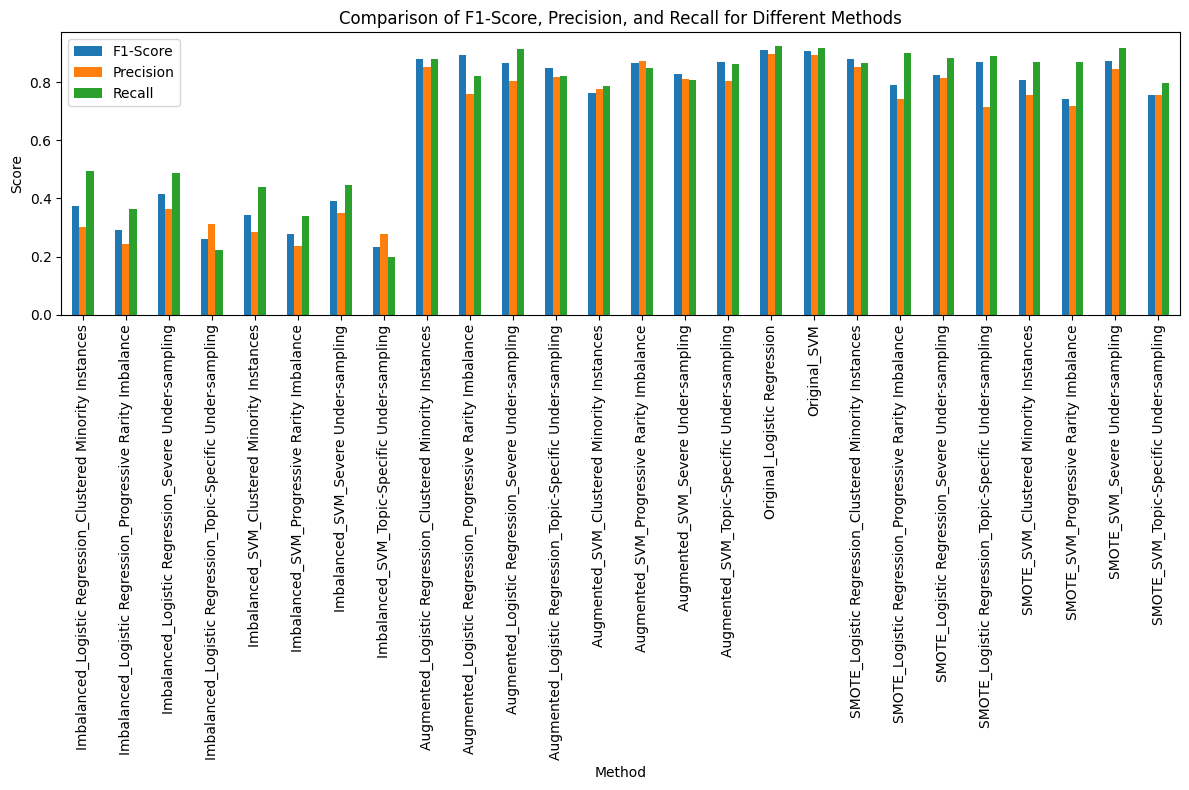

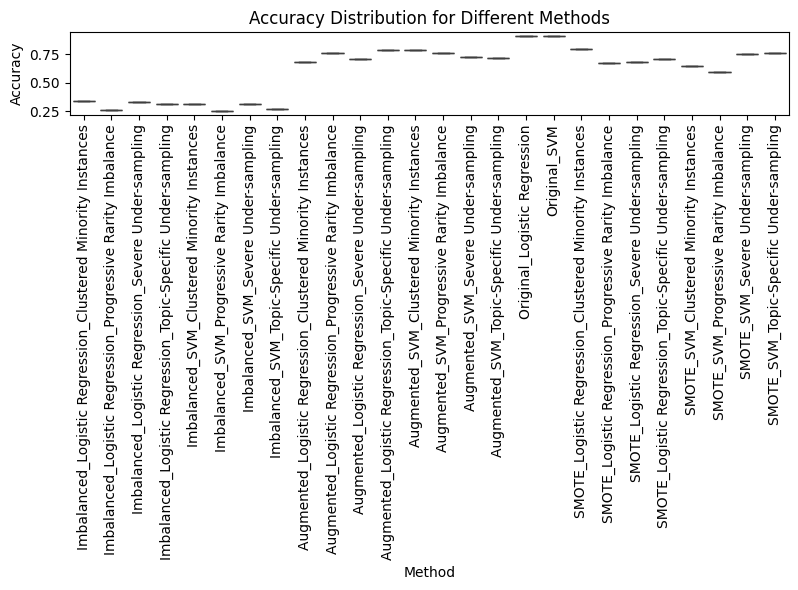

<Figure size 1200x800 with 0 Axes>

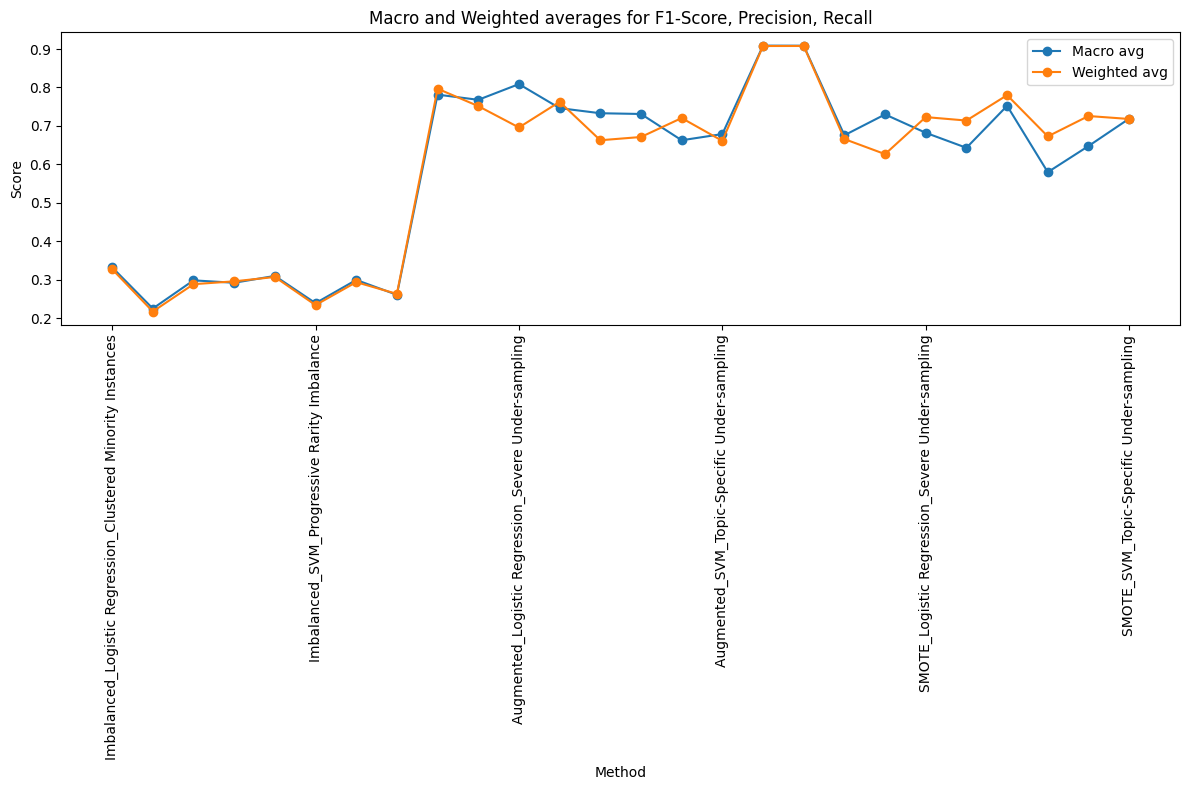

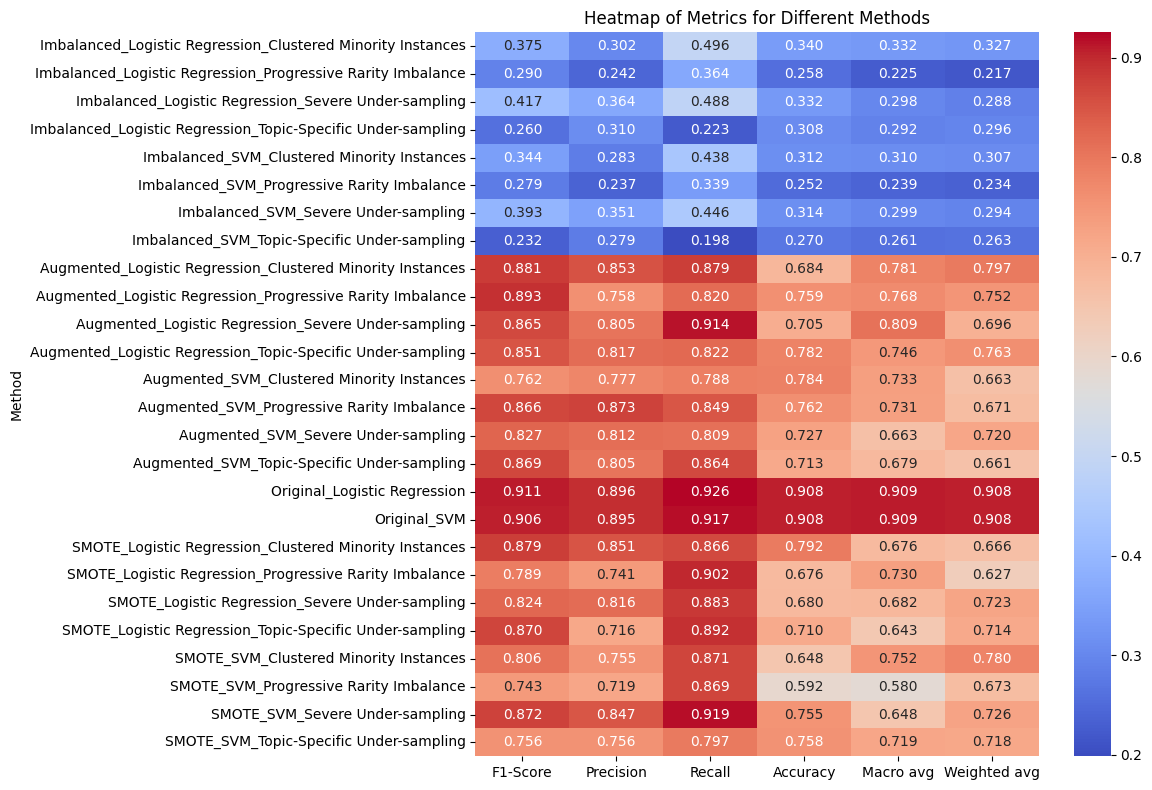

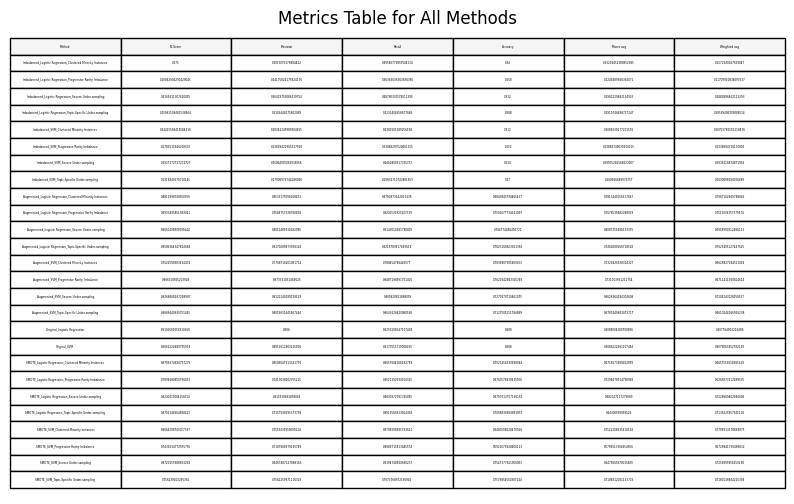

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `data_dict` is already defined
methods = list(dict_data.keys())  # Extract all method names from the dictionary
metrics_data = {
    'Method': methods,
    'F1-Score': [dict_data[method]['0']['f1-score'] for method in methods],
    'Precision': [dict_data[method]['0']['precision'] for method in methods],
    'Recall': [dict_data[method]['0']['recall'] for method in methods],
    'Accuracy': [dict_data[method]['accuracy'] for method in methods],
    'Macro avg': [dict_data[method]['macro avg']['f1-score'] for method in methods],
    'Weighted avg': [dict_data[method]['weighted avg']['f1-score'] for method in methods]
}

# Create a DataFrame
df = pd.DataFrame(metrics_data)

# Bar Plot for F1-Score, Precision, Recall (Comparison)
plt.figure(figsize=(12, 8))
df.set_index('Method')[['F1-Score', 'Precision', 'Recall']].plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of F1-Score, Precision, and Recall for Different Methods')
plt.ylabel('Score')
plt.xlabel('Method')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Box Plot for Accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x='Method', y='Accuracy', data=df)
plt.title('Accuracy Distribution for Different Methods')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Line Plot for Macro and Weighted averages (F1-Score, Precision, Recall)
plt.figure(figsize=(12, 8))
df.set_index('Method')[['Macro avg', 'Weighted avg']].plot(kind='line', marker='o', figsize=(12, 8))
plt.title('Macro and Weighted averages for F1-Score, Precision, Recall')
plt.ylabel('Score')
plt.xlabel('Method')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Heatmap for Method vs. Metrics
metrics = ['F1-Score', 'Precision', 'Recall', 'Accuracy', 'Macro avg', 'Weighted avg']
heatmap_data = df.set_index('Method')[metrics]  # Ensure 'Method' is the index
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Heatmap of Metrics for Different Methods')
plt.tight_layout()
plt.show()

# Display the DataFrame as a Table
plt.figure(figsize=(10, 6))
plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=["#f5f5f5"]*len(df.columns))
plt.axis('off')
plt.title('Metrics Table for All Methods')
plt.show()


<ipython-input-8-dbf19aaec4e7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='F1-Score', data=subset_df, palette='muted')


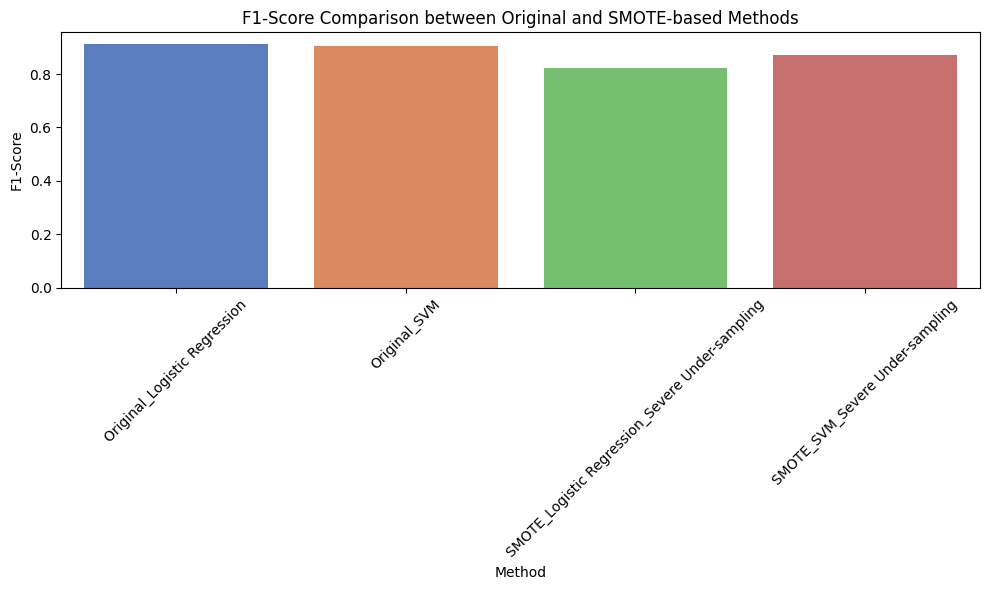

In [ ]:
# Example: Compare F1-Score for Original vs SMOTE-based methods
subset_methods = ['Original_Logistic Regression', 'Original_SVM', 'SMOTE_Logistic Regression_Severe Under-sampling',
                  'SMOTE_SVM_Severe Under-sampling']  # Modify as per your interest

subset_df = df[df['Method'].isin(subset_methods)]

# F1-Score comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='F1-Score', data=subset_df, palette='muted')
plt.title('F1-Score Comparison between Original and SMOTE-based Methods')
plt.xlabel('Method')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


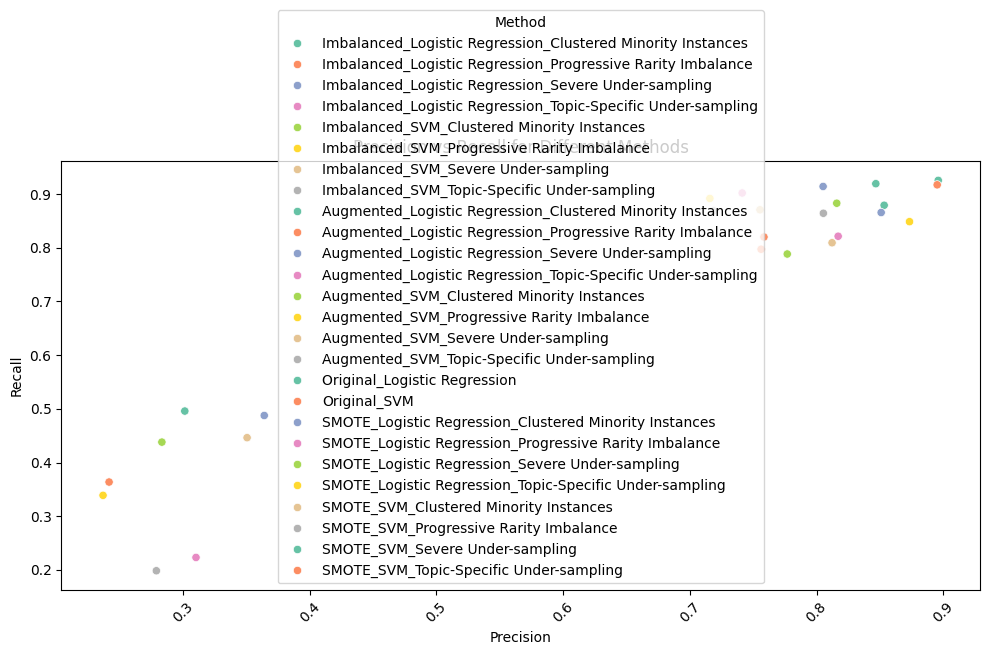

In [ ]:
# Scatter plot for Precision vs Recall
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Precision', y='Recall', hue='Method', data=df, palette='Set2')
plt.title('Precision vs Recall for Different Methods')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


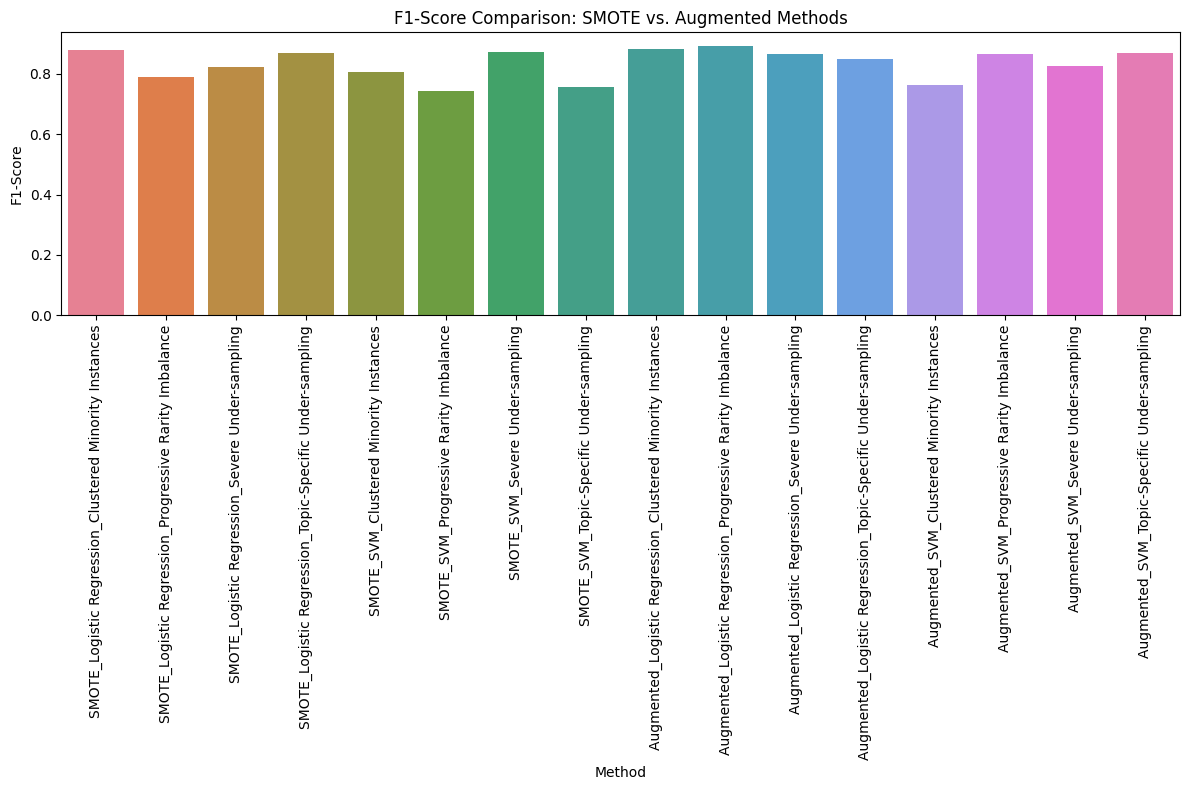

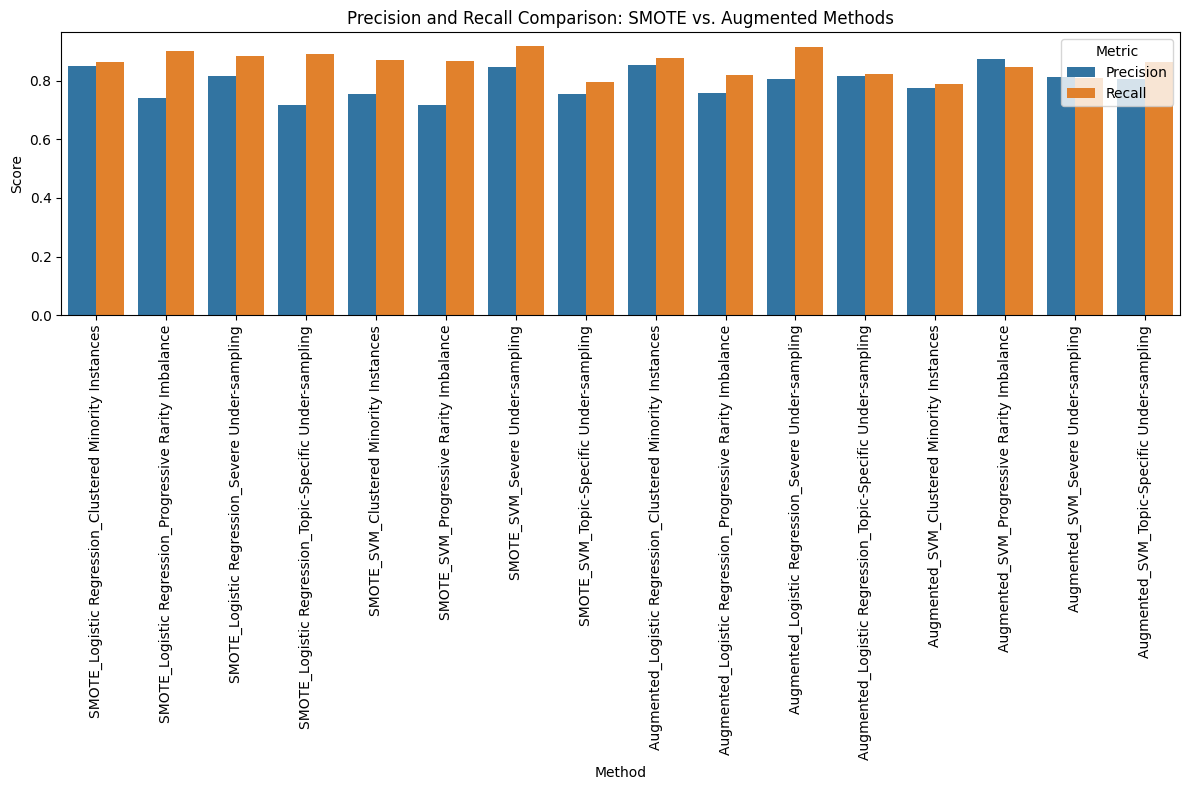

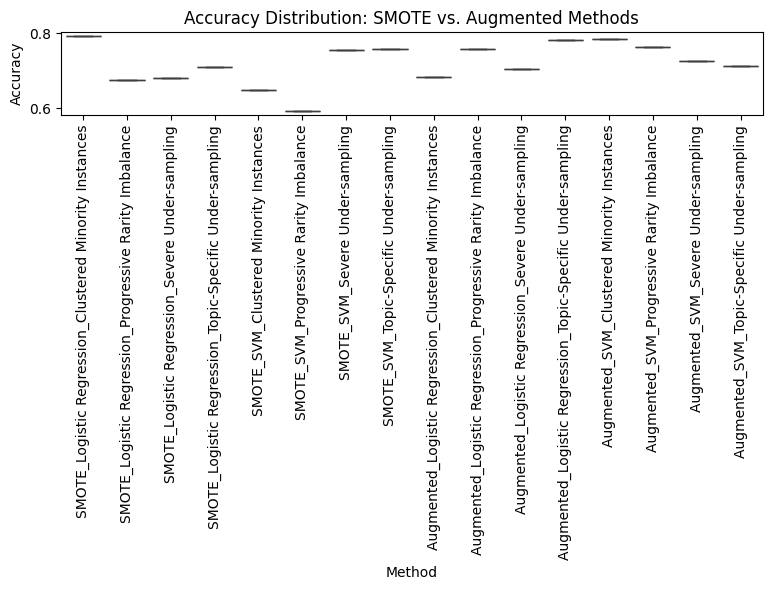

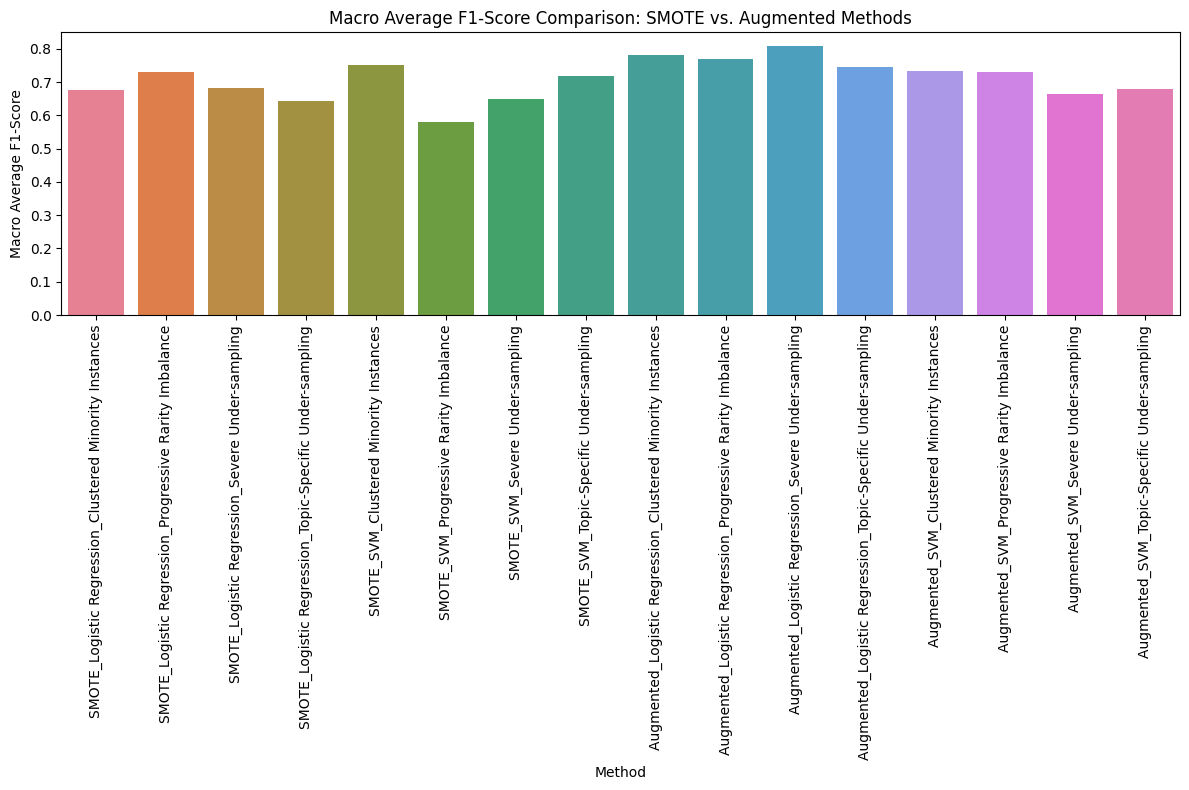

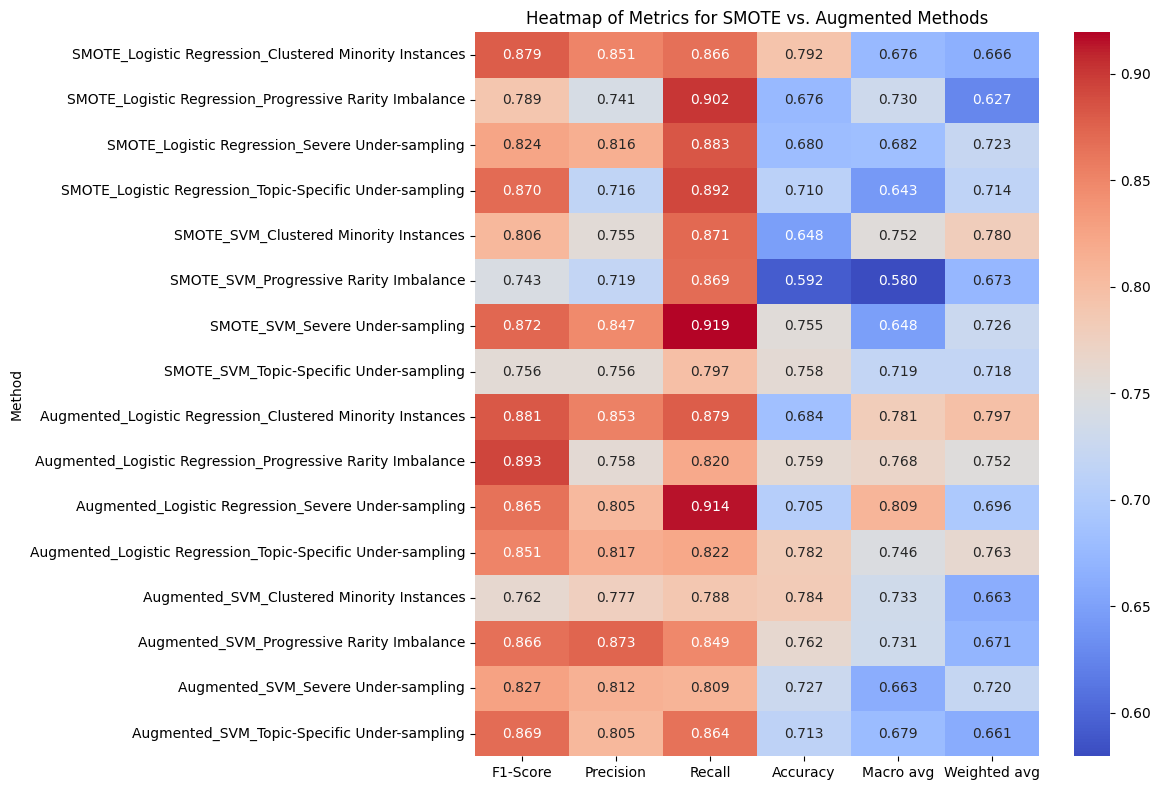

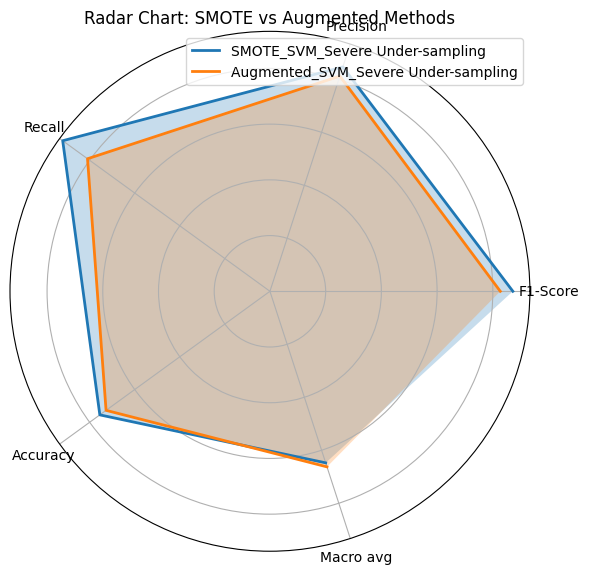

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `data_dict` is already defined and contains the data

# Extracting the methods for SMOTE and Augmented
smote_methods = [key for key in dict_data.keys() if 'SMOTE' in key]
augmented_methods = [key for key in dict_data.keys() if 'Augmented' in key]

# Prepare a DataFrame with the metrics to compare SMOTE and Augmented methods
methods = smote_methods + augmented_methods

metrics_data = {
    'Method': methods,
    'F1-Score': [dict_data[method]['0']['f1-score'] for method in methods],
    'Precision': [dict_data[method]['0']['precision'] for method in methods],
    'Recall': [dict_data[method]['0']['recall'] for method in methods],
    'Accuracy': [dict_data[method]['accuracy'] for method in methods],
    'Macro avg': [dict_data[method]['macro avg']['f1-score'] for method in methods],
    'Weighted avg': [dict_data[method]['weighted avg']['f1-score'] for method in methods]
}

df = pd.DataFrame(metrics_data)

# 1. **F1-Score Comparison (SMOTE vs. Augmented Methods)**
plt.figure(figsize=(12, 8))
sns.barplot(x='Method', y='F1-Score', data=df, hue='Method', dodge=False)
plt.title('F1-Score Comparison: SMOTE vs. Augmented Methods')
plt.xticks(rotation=90)
plt.ylabel('F1-Score')
plt.xlabel('Method')
plt.tight_layout()
plt.show()

# 2. **Precision and Recall Comparison (SMOTE vs. Augmented Methods)**
plt.figure(figsize=(12, 8))
df_melted = df.melt(id_vars='Method', value_vars=['Precision', 'Recall'], var_name='Metric', value_name='Score')
sns.barplot(x='Method', y='Score', hue='Metric', data=df_melted, dodge=True)
plt.title('Precision and Recall Comparison: SMOTE vs. Augmented Methods')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.xlabel('Method')
plt.tight_layout()
plt.show()

# 3. **Accuracy Comparison (Box Plot for SMOTE vs. Augmented Methods)**
plt.figure(figsize=(8, 6))
sns.boxplot(x='Method', y='Accuracy', data=df)
plt.title('Accuracy Distribution: SMOTE vs. Augmented Methods')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Method')
plt.tight_layout()
plt.show()

# 4. **Macro Average F1-Score Comparison (Bar Plot)**
plt.figure(figsize=(12, 8))
sns.barplot(x='Method', y='Macro avg', data=df, hue='Method', dodge=False)
plt.title('Macro Average F1-Score Comparison: SMOTE vs. Augmented Methods')
plt.xticks(rotation=90)
plt.ylabel('Macro Average F1-Score')
plt.xlabel('Method')
plt.tight_layout()
plt.show()

# 5. **Heatmap for SMOTE vs. Augmented Methods (F1-Score, Precision, Recall, Accuracy)**
metrics = ['F1-Score', 'Precision', 'Recall', 'Accuracy', 'Macro avg', 'Weighted avg']
heatmap_data = df.set_index('Method')[metrics]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Heatmap of Metrics for SMOTE vs. Augmented Methods')
plt.tight_layout()
plt.show()

# 6. **Radar Chart for SMOTE vs. Augmented Methods**
# Select a few methods for radar chart comparison
selected_methods = ['SMOTE_SVM_Severe Under-sampling', 'Augmented_SVM_Severe Under-sampling']
metrics_values = []

for method in selected_methods:
    metrics_values.append([
        dict_data[method]['0']['f1-score'],
        dict_data[method]['0']['precision'],
        dict_data[method]['0']['recall'],
        dict_data[method]['accuracy'],
        dict_data[method]['macro avg']['f1-score']
    ])

# Radar chart settings
labels = ['F1-Score', 'Precision', 'Recall', 'Accuracy', 'Macro avg']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
metrics_values = np.array(metrics_values)

# Plotting radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})
for i, method in enumerate(selected_methods):
    ax.plot(angles, metrics_values[i], linewidth=2, label=method)
    ax.fill(angles, metrics_values[i], alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(labels)
plt.title('Radar Chart: SMOTE vs Augmented Methods')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
